<a href="https://colab.research.google.com/github/KeeJin/SCL/blob/master/SCL_Marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x

In [ ]:
!nvidia-smi

Sat Aug  8 00:51:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import necessary libraries

In [ ]:
!pip install -U keras-tuner

     |████████████████████████████████| 61kB 3.1MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=b98c4c477961ab81deb0fb1cf94df0c61489a9213f968e28dc860f35b4cad6a1
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=d1285eae934aa65d55f8aaf408ade650824c049e798c5840ea3358a1876175e6
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import SGD
from tensorflow import keras

from kerastuner.tuners import RandomSearch
import kerastuner

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Loading the data

In [ ]:
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
%cd  ../gdrive/My\ Drive/Marketing_Analytics

/gdrive/My Drive/Marketing_Analytics


In [ ]:
!ls

catdata_01.npy			      NEWcombdata_04.npy
catdata_02.npy			      NEWnumdata_01.npy
catdata_best_weights.hdf5	      normaltest_df.csv
combdata			      numdata
combdata_attr1			      numdata_01.npy
combdata_best_weights_bestmodel.hdf5  numdata_02.npy
combdata_best_weights.hdf5	      numdata_03.npy
combdata_best_weights_testage.hdf5    numdata_04.npy
combdata_best_weights_testattr1.hdf5  numdata_best_weights.hdf5
combdata_bigger			      sample_submission_0_1.csv
combdata_tpu			      submission.csv
NEWcatdata_01.npy		      test.csv
NEWcombdata_01.npy		      train.csv
NEWcombdata_02.npy		      users.csv
NEWcombdata_03.npy


In [ ]:
train_df = pd.read_csv('train.csv')
train_df = train_df.drop(['last_open_day', 'last_login_day', 'last_checkout_day'], axis = 1)
print(len(train_df))
train_df.head()

73539


,country_code,grass_date,user_id,subject_line_length,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,open_flag,row_id
0,4,2019-07-16 00:00:00+08:00,43,44,0,2,4,12,43,99,0,5,10,0,0
1,4,2019-07-16 00:00:00+08:00,102,44,2,9,17,18,48,90,1,1,4,1,1
2,6,2019-07-16 00:00:00+08:00,177,49,0,4,12,24,69,119,5,19,27,0,2
3,1,2019-07-16 00:00:00+08:00,184,49,0,0,1,9,23,69,1,3,6,0,3
4,6,2019-07-16 00:00:00+08:00,221,49,0,0,0,2,5,5,0,0,0,0,4


In [ ]:
test_df = pd.read_csv('test.csv')
print(len(test_df))
test_df.head()

55970


,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,row_id
0,6,2019-09-03 00:00:00+08:00,0,35,27,2,13,2,3,4,10,34,134,0,6,18,0
1,6,2019-09-03 00:00:00+08:00,130,35,7,5,383,1,1,1,5,5,5,0,0,0,1
2,5,2019-09-03 00:00:00+08:00,150,25,34,1,3,0,0,0,13,19,38,2,2,2,2
3,1,2019-09-03 00:00:00+08:00,181,36,63,5,5,0,0,0,43,110,173,2,5,5,3
4,5,2019-09-03 00:00:00+08:00,192,23,6,5,54,0,0,0,4,12,39,0,0,2,4


In [ ]:
users_df = pd.read_csv('users.csv')
print(len(users_df))
print(len(test_df)+len(train_df))
users_df.head(10)

127886
129509


,user_id,attr_1,attr_2,attr_3,age,domain
0,0,NaN,1.0,0.0,NaN,@gmail.com
1,1,1.0,1.0,2.0,50.0,@gmail.com
2,2,NaN,1.0,0.0,NaN,other
3,3,NaN,1.0,0.0,NaN,@gmail.com
4,4,1.0,1.0,2.0,33.0,@gmail.com
5,5,1.0,1.0,1.0,30.0,@gmail.com
6,6,1.0,1.0,2.0,32.0,@gmail.com
7,7,1.0,1.0,1.0,36.0,@gmail.com
8,8,1.0,1.0,1.0,43.0,@yahoo.com
9,9,NaN,1.0,0.0,NaN,@gmail.com


In [ ]:
sample = pd.read_csv('sample_submission_0_1.csv')
sample.head()

,row_id,open_flag
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


## Exploratory Data Analysis

grass_date: The date when the email was sent.  

####**NUMERIC VARIABLES:**  
subject_line_length:  the number of characters in the subject of the email  
open_count_last_10 / 30 / 60_days: the total number of email opens in the last N days.  
login_count_last_10 / 30 / 60_days: the total number of user logins in the last N days.  
checkout_count_last_10 / 30 / 60_days: the total number of checkouts by the user in the last N days.  
age: The user's reported age.  

####**CATEGORICAL VARIABLES:**  
country_code: An integer code for the country where the user lives  
attr_1 / 2 / 3: general user attributes.  
domain: The user's top level email domain. Less common domains are bundled together under the label 'other'.  

####**RESULT:**  
open_flag: the target variable. Whether or not the email was opened.   

### Preparing the data

In [ ]:
def time_to_categorical_series(df,type="hour"):
    if type == "hour":
        return df['grass_date'].dt.hour.astype('category')
    elif type == "dayofweek":
        return df['grass_date'].dt.dayofweek.astype('category')
    elif type == "month":
        return df['grass_date'].dt.month.astype('category')
    else:
        return None
    
def time_to_categorical(df):
    hour_series = time_to_categorical_series(df,type='hour')
    dayofweek_series = time_to_categorical_series(df,type='dayofweek')
    month_series = time_to_categorical_series(df,type='month')

    df['hour'] = hour_series
    df['dayofweek'] = dayofweek_series
    df['month'] = month_series

In [ ]:
train_df['grass_date'] = pd.to_datetime(train_df['grass_date'])
train_df.dtypes

country_code                                                   int64
grass_date                     datetime64[ns, pytz.FixedOffset(480)]
user_id                                                        int64
subject_line_length                                            int64
open_count_last_10_days                                        int64
open_count_last_30_days                                        int64
open_count_last_60_days                                        int64
login_count_last_10_days                                       int64
login_count_last_30_days                                       int64
login_count_last_60_days                                       int64
checkout_count_last_10_days                                    int64
checkout_count_last_30_days                                    int64
checkout_count_last_60_days                                    int64
open_flag                                                      int64
row_id                            

In [ ]:
time_to_categorical(train_df)
train_df.head()

,country_code,grass_date,user_id,subject_line_length,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,open_flag,row_id,hour,dayofweek,month
0,4,2019-07-16 00:00:00+08:00,43,44,0,2,4,12,43,99,0,5,10,0,0,0,1,7
1,4,2019-07-16 00:00:00+08:00,102,44,2,9,17,18,48,90,1,1,4,1,1,0,1,7
2,6,2019-07-16 00:00:00+08:00,177,49,0,4,12,24,69,119,5,19,27,0,2,0,1,7
3,1,2019-07-16 00:00:00+08:00,184,49,0,0,1,9,23,69,1,3,6,0,3,0,1,7
4,6,2019-07-16 00:00:00+08:00,221,49,0,0,0,2,5,5,0,0,0,0,4,0,1,7


In [ ]:
train_comb = pd.merge(train_df, users_df, on = 'user_id', how = 'left')
print(len(train_comb))
train_comb.head()

73539


,country_code,grass_date,user_id,subject_line_length,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,open_flag,row_id,hour,dayofweek,month,attr_1,attr_2,attr_3,age,domain
0,4,2019-07-16 00:00:00+08:00,43,44,0,2,4,12,43,99,0,5,10,0,0,0,1,7,1.0,1.0,2.0,47.0,@gmail.com
1,4,2019-07-16 00:00:00+08:00,102,44,2,9,17,18,48,90,1,1,4,1,1,0,1,7,1.0,1.0,2.0,25.0,@hotmail.com
2,6,2019-07-16 00:00:00+08:00,177,49,0,4,12,24,69,119,5,19,27,0,2,0,1,7,NaN,1.0,0.0,NaN,@yahoo.com
3,1,2019-07-16 00:00:00+08:00,184,49,0,0,1,9,23,69,1,3,6,0,3,0,1,7,1.0,1.0,2.0,24.0,@yahoo.com
4,6,2019-07-16 00:00:00+08:00,221,49,0,0,0,2,5,5,0,0,0,0,4,0,1,7,NaN,1.0,0.0,NaN,@hotmail.com


In [ ]:
train_comb.groupby('month').agg('count')

,country_code,grass_date,user_id,subject_line_length,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,open_flag,row_id,hour,dayofweek,attr_1,attr_2,attr_3,age,domain
month,,,,,,,,,,,,,,,,,,,,,,
7,23301,23301,23301,23301,23301,23301,23301,23301,23301,23301,23301,23301,23301,23301,23301,23301,23301,14204,23038,23301,14204,23301
8,43358,43358,43358,43358,43358,43358,43358,43358,43358,43358,43358,43358,43358,43358,43358,43358,43358,26843,43345,43358,26843,43358
9,6880,6880,6880,6880,6880,6880,6880,6880,6880,6880,6880,6880,6880,6880,6880,6880,6880,4300,6877,6880,4300,6880


In [ ]:
train_comb[['open_flag', 'attr_1', 'attr_2', 'attr_3', 'country_code', 'domain', 'dayofweek', 'month']] = train_comb[['open_flag', 'attr_1', 'attr_2', 'attr_3', 'country_code', 'domain', 'dayofweek', 'month']].apply(lambda x: x.astype('category'))
# train_comb['open_flag'] = train_comb['open_flag'].astype('category')
train_comb = train_comb.drop(columns = 'attr_1')

In [ ]:
# train_comb['attr_1'] = train_comb['attr_1'].astype(float)
# train_comb['attr_1'] = train_comb['attr_1'].fillna(2.0)
# train_comb['attr_1'] = train_comb['attr_1'].astype('category')

In [ ]:
train_comb.dtypes

country_code                                                category
grass_date                     datetime64[ns, pytz.FixedOffset(480)]
user_id                                                        int64
subject_line_length                                            int64
open_count_last_10_days                                        int64
open_count_last_30_days                                        int64
open_count_last_60_days                                        int64
login_count_last_10_days                                       int64
login_count_last_30_days                                       int64
login_count_last_60_days                                       int64
checkout_count_last_10_days                                    int64
checkout_count_last_30_days                                    int64
checkout_count_last_60_days                                    int64
open_flag                                                   category
row_id                            

In [ ]:
train_comb.isna().sum()

country_code                       0
grass_date                         0
user_id                            0
subject_line_length                0
open_count_last_10_days            0
open_count_last_30_days            0
open_count_last_60_days            0
login_count_last_10_days           0
login_count_last_30_days           0
login_count_last_60_days           0
checkout_count_last_10_days        0
checkout_count_last_30_days        0
checkout_count_last_60_days        0
open_flag                          0
row_id                             0
hour                               0
dayofweek                          0
month                              0
attr_2                           279
attr_3                             0
age                            28192
domain                             0
dtype: int64

### NUMERIC VARIABLES

In [ ]:
train_numeric = train_comb[['user_id', 'subject_line_length', 'open_count_last_10_days', 'open_count_last_30_days', 'open_count_last_60_days', 
                            'login_count_last_10_days', 'login_count_last_30_days', 'login_count_last_60_days', 
                            'checkout_count_last_10_days', 'checkout_count_last_30_days', 'checkout_count_last_60_days', 'age', 'open_flag']]
print(train_numeric.dtypes)
train_numeric.head(10)

user_id                           int64
subject_line_length               int64
open_count_last_10_days           int64
open_count_last_30_days           int64
open_count_last_60_days           int64
login_count_last_10_days          int64
login_count_last_30_days          int64
login_count_last_60_days          int64
checkout_count_last_10_days       int64
checkout_count_last_30_days       int64
checkout_count_last_60_days       int64
age                             float64
open_flag                      category
dtype: object


,user_id,subject_line_length,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,age,open_flag
0,43,44,0,2,4,12,43,99,0,5,10,47.0,0
1,102,44,2,9,17,18,48,90,1,1,4,25.0,1
2,177,49,0,4,12,24,69,119,5,19,27,NaN,0
3,184,49,0,0,1,9,23,69,1,3,6,24.0,0
4,221,49,0,0,0,2,5,5,0,0,0,NaN,0
5,246,44,3,7,13,6,18,45,0,0,7,35.0,0
6,258,43,0,0,0,9,32,46,2,3,3,22.0,0
7,288,49,0,0,0,4,19,45,0,5,7,22.0,0
8,350,49,2,4,7,1,8,10,0,1,1,NaN,1
9,417,44,2,6,14,6,11,17,0,1,1,31.0,0


In [ ]:
# Check for NA values
train_numeric.isna().sum()

user_id                            0
subject_line_length                0
open_count_last_10_days            0
open_count_last_30_days            0
open_count_last_60_days            0
login_count_last_10_days           0
login_count_last_30_days           0
login_count_last_60_days           0
checkout_count_last_10_days        0
checkout_count_last_30_days        0
checkout_count_last_60_days        0
age                            28192
open_flag                          0
dtype: int64

In [ ]:
# Let's check the proportion of missing 'age' values.

missing_age_values = train_numeric['age'].isna().sum()
print("Percentage of missing 'age' values: {:.2f}%".format(missing_age_values/len(train_numeric)*100))

Percentage of missing 'age' values: 38.34%


In [ ]:
####### TODO #######

## Decide how to deal with NA ages: remove or impute? 
## If impute, impute with what? 0? mean? median?


##### overall

In [ ]:
train_numeric.loc[:,'subject_line_length':].describe()

,subject_line_length,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,age
count,73539.000000,73539.000000,73539.000000,73539.000000,73539.000000,73539.000000,73539.000000,73539.000000,73539.000000,73539.000000,45347.000000
mean,43.656373,0.911829,2.780457,5.019364,8.382287,25.284053,49.010430,0.909898,2.796040,5.420960,31.445564
std,11.219323,1.754052,4.570239,7.902313,13.424436,37.853189,71.819327,2.887416,7.686064,13.980182,11.797405
min,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-17.000000
25%,34.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,24.000000
50%,43.000000,0.000000,1.000000,2.000000,3.000000,11.000000,22.000000,0.000000,0.000000,1.000000,29.000000
75%,52.000000,1.000000,3.000000,6.000000,12.000000,35.000000,69.000000,1.000000,3.000000,6.000000,36.000000
max,75.000000,31.000000,92.000000,135.000000,254.000000,735.000000,1260.000000,157.000000,531.000000,783.000000,118.000000


In [ ]:
# train_numeric.loc[:,'subject_line_length':].mode()
# train_numeric.loc[:,'subject_line_length':].median()

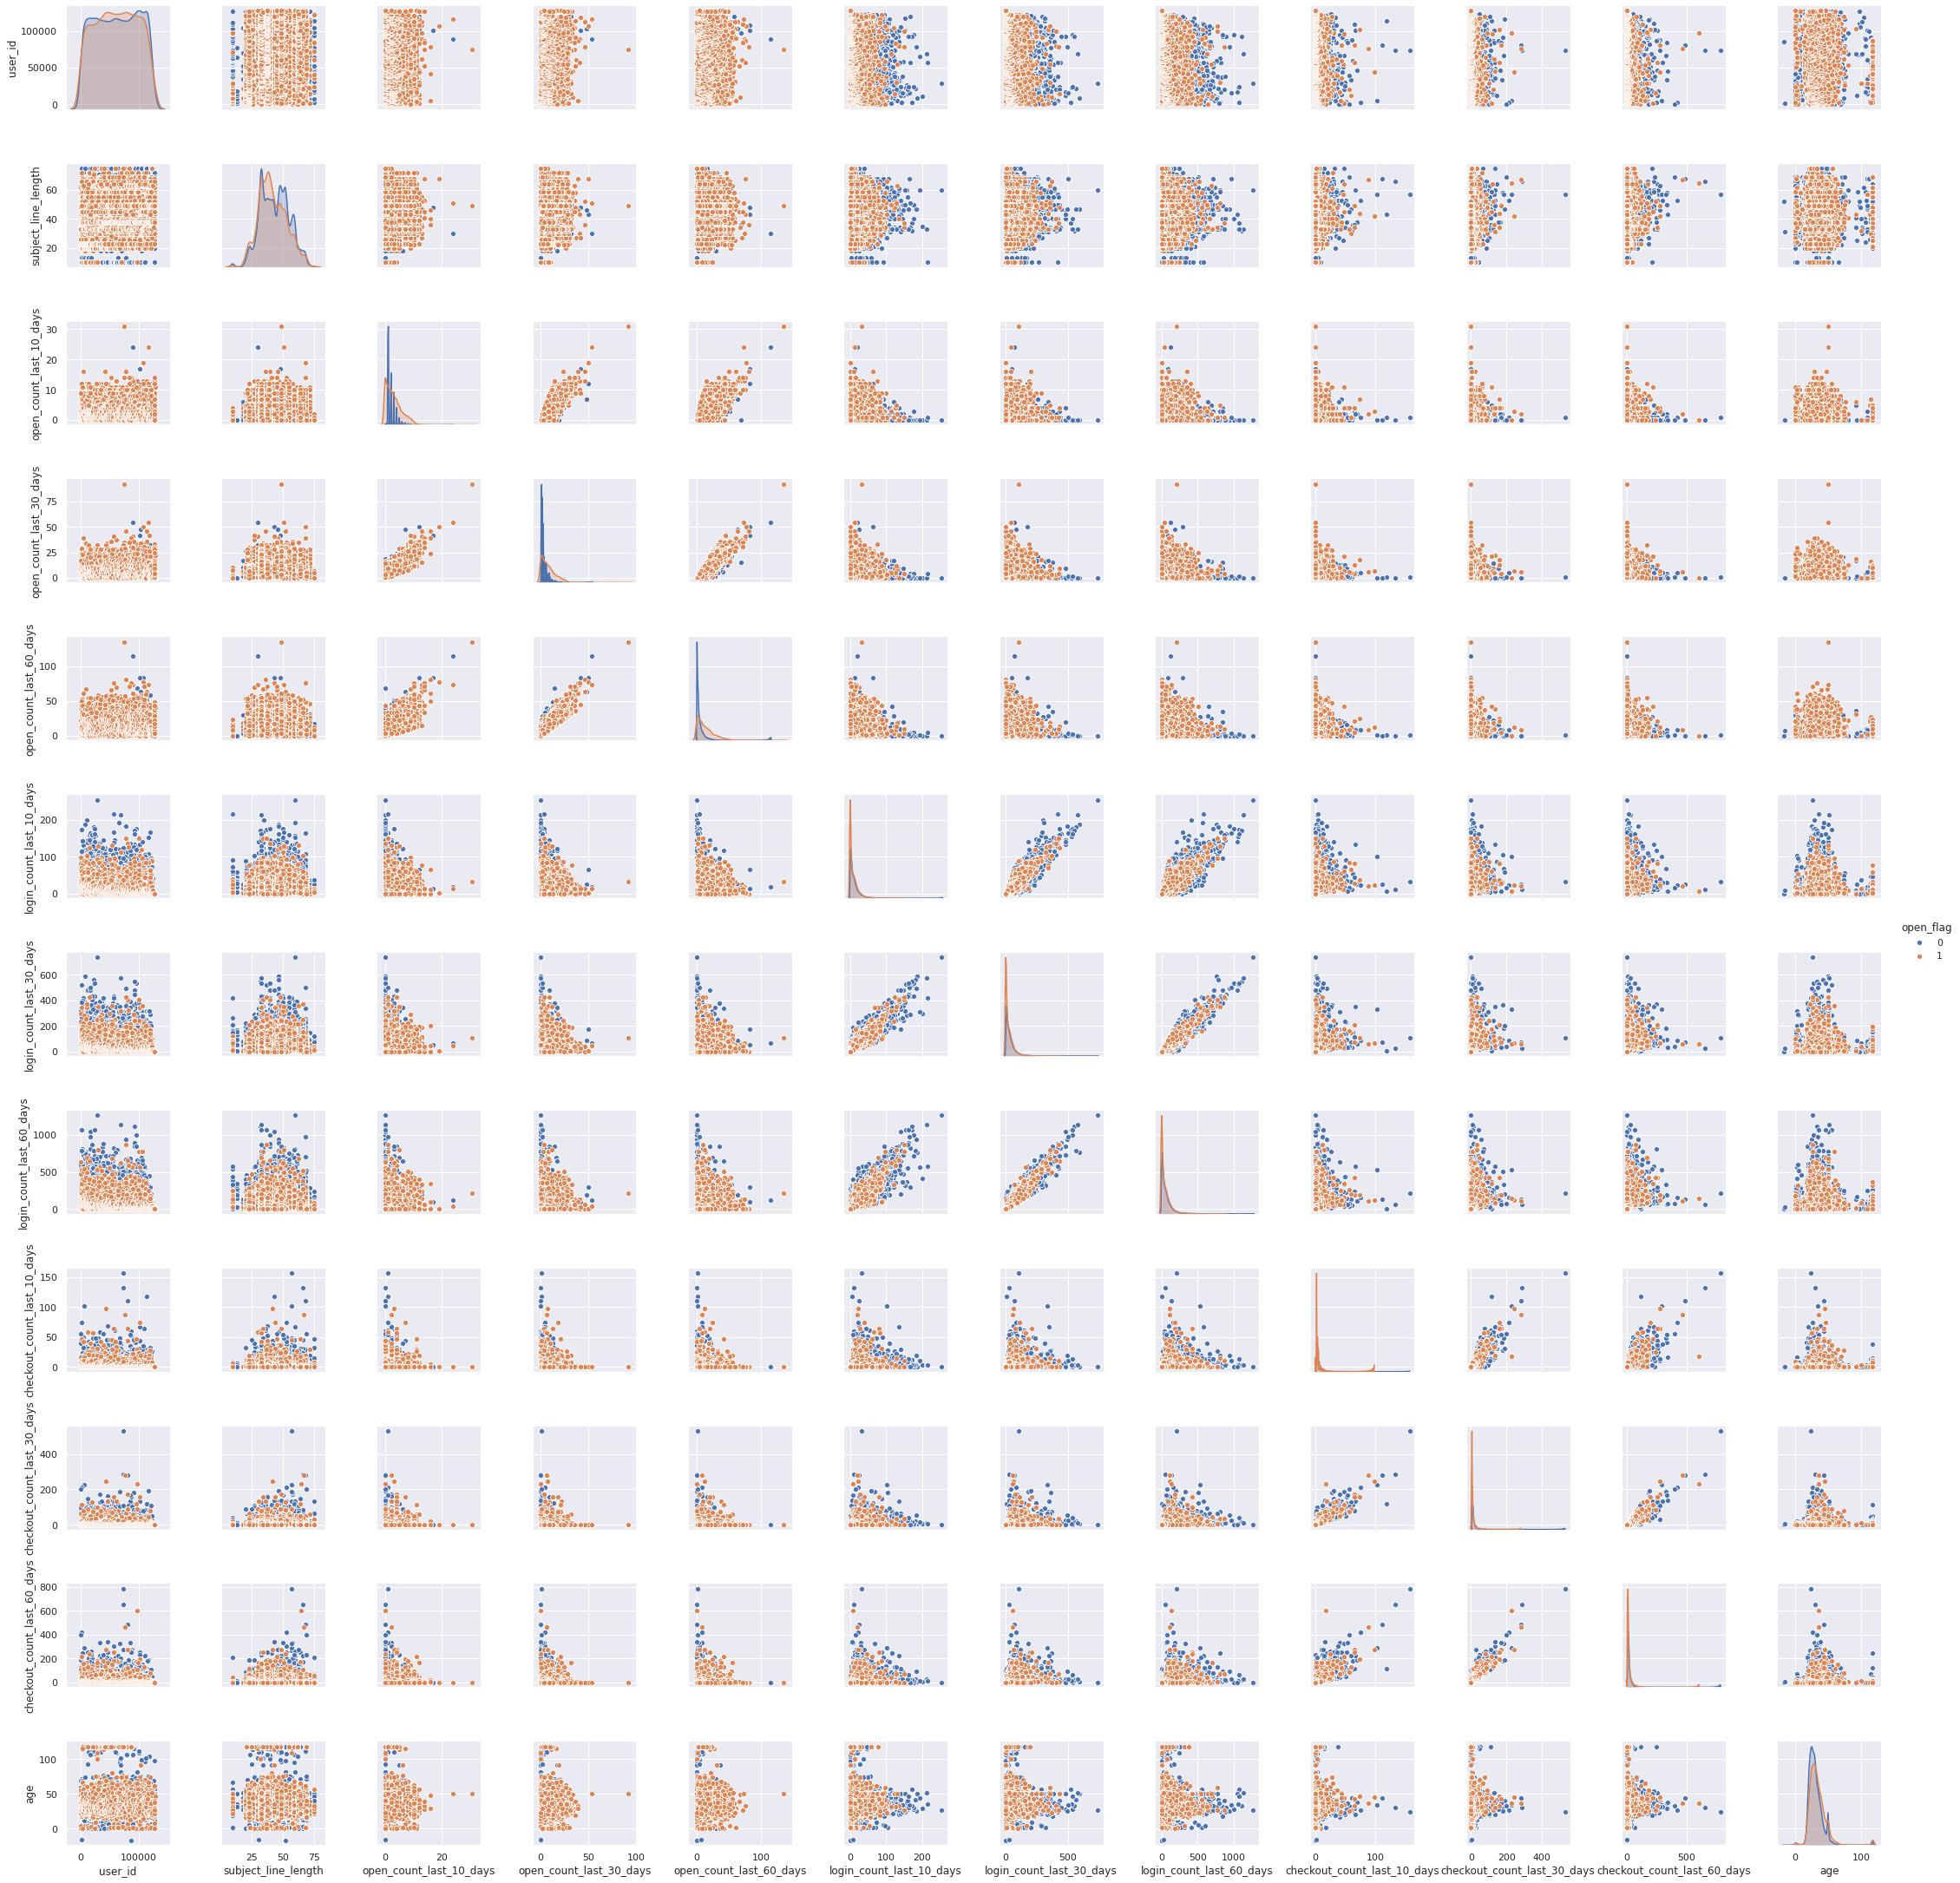

In [ ]:
# sb.pairplot(train_numeric, kind = 'scatter', height = 60, aspect = 1)
sb.pairplot(train_numeric, hue = 'open_flag')

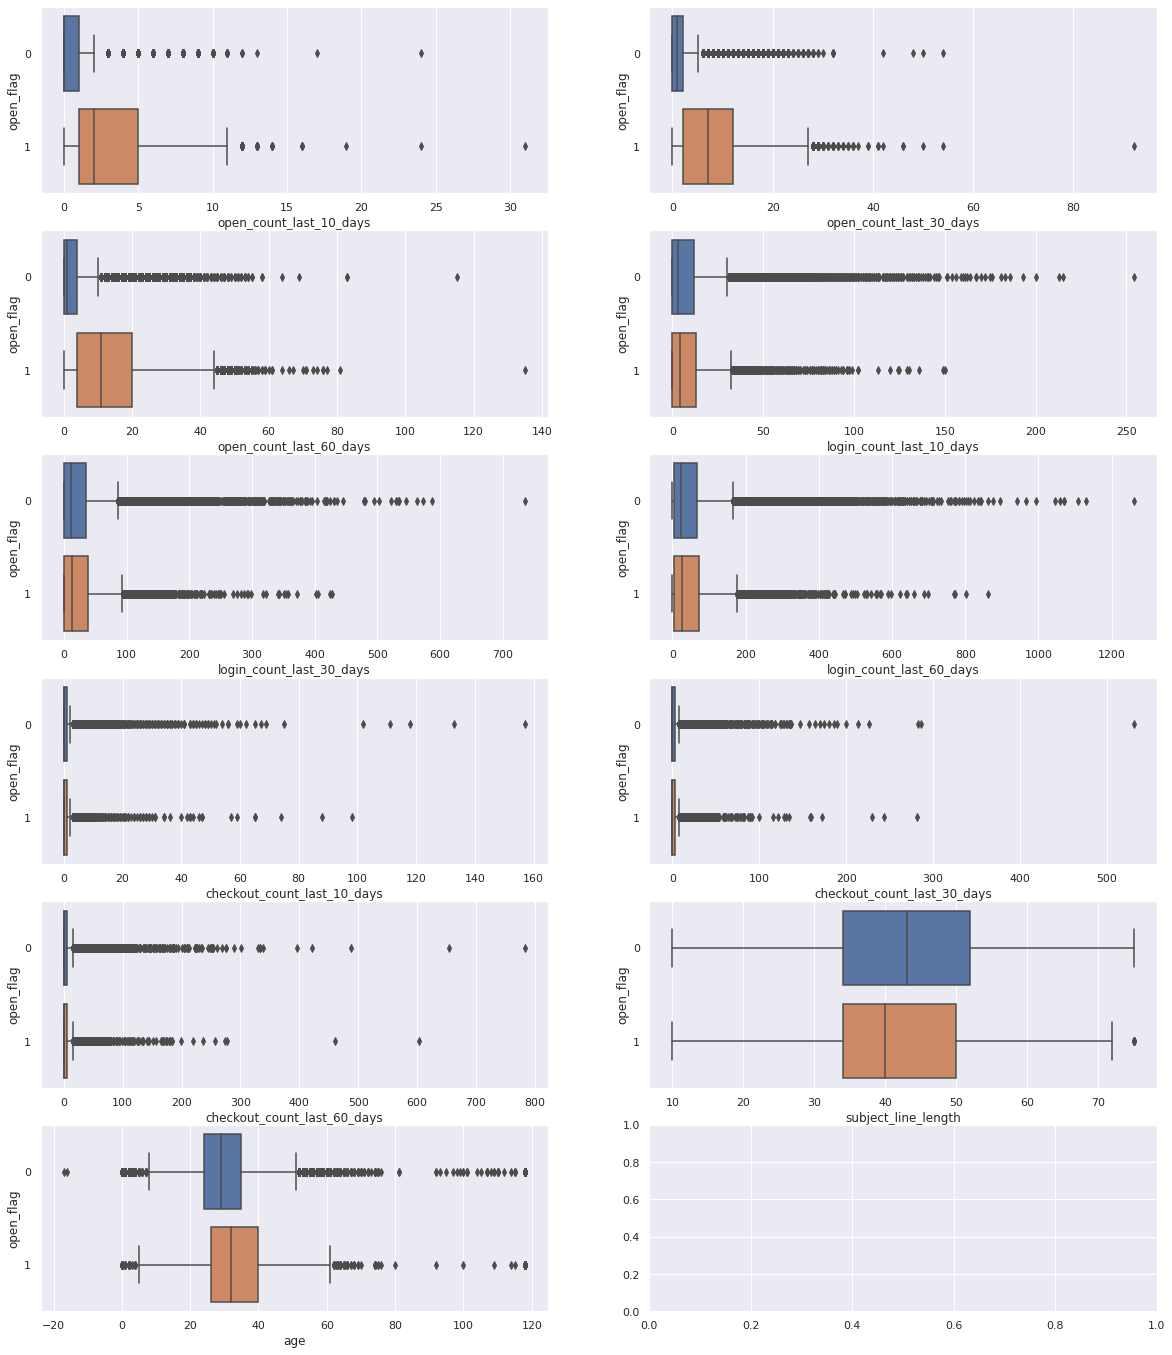

In [ ]:
fig, ax =plt.subplots(6,2, figsize=(20,24))

sb.boxplot(data = train_numeric, x = 'open_count_last_10_days', y = 'open_flag', ax = ax[0,0])
sb.boxplot(data = train_numeric, x = 'open_count_last_30_days', y = 'open_flag', ax = ax[0,1])
sb.boxplot(data = train_numeric, x = 'open_count_last_60_days', y = 'open_flag', ax = ax[1,0])
sb.boxplot(data = train_numeric, x = 'login_count_last_10_days', y = 'open_flag', ax = ax[1,1])
sb.boxplot(data = train_numeric, x = 'login_count_last_30_days', y = 'open_flag', ax = ax[2,0])
sb.boxplot(data = train_numeric, x = 'login_count_last_60_days', y = 'open_flag', ax = ax[2,1])
sb.boxplot(data = train_numeric, x = 'checkout_count_last_10_days', y = 'open_flag', ax = ax[3,0])
sb.boxplot(data = train_numeric, x = 'checkout_count_last_30_days', y = 'open_flag', ax = ax[3,1])
sb.boxplot(data = train_numeric, x = 'checkout_count_last_60_days', y = 'open_flag', ax = ax[4,0])
sb.boxplot(data = train_numeric, x = 'subject_line_length', y = 'open_flag', ax = ax[4,1])
sb.boxplot(data = train_numeric, x = 'age', y = 'open_flag', ax = ax[5,0])

plt.show()

### CATEGORICAL VARIABLES

In [ ]:
train_categorical = train_comb[['user_id', 'country_code', 'attr_2', 'attr_3', 'domain', 'open_flag', 'dayofweek', 'month']]
print(train_categorical.dtypes)
train_categorical.head(10)

user_id            int64
country_code    category
attr_2          category
attr_3          category
domain          category
open_flag       category
dayofweek       category
month           category
dtype: object


,user_id,country_code,attr_2,attr_3,domain,open_flag,dayofweek,month
0,43,4,1.0,2.0,@gmail.com,0,1,7
1,102,4,1.0,2.0,@hotmail.com,1,1,7
2,177,6,1.0,0.0,@yahoo.com,0,1,7
3,184,1,1.0,2.0,@yahoo.com,0,1,7
4,221,6,1.0,0.0,@hotmail.com,0,1,7
5,246,4,1.0,2.0,@gmail.com,0,1,7
6,258,5,1.0,2.0,@gmail.com,0,1,7
7,288,6,1.0,2.0,@gmail.com,0,1,7
8,350,1,1.0,0.0,@yahoo.com,1,1,7
9,417,4,1.0,2.0,@gmail.com,0,1,7


In [ ]:
train_categorical.groupby('open_flag').agg('count')

,user_id,country_code,attr_2,attr_3,domain,dayofweek,month
open_flag,,,,,,,
0,62083,62083,61878,62083,62083,62083,62083
1,11456,11456,11382,11456,11456,11456,11456


In [ ]:
train_categorical.isna().sum()

user_id           0
country_code      0
attr_2          279
attr_3            0
domain            0
open_flag         0
dayofweek         0
month             0
dtype: int64

In [ ]:
# Let's check the proportion of missing values in 'attr_1 and 'attr_2'.

missing_attr1_values = train_categorical['attr_1'].isna().sum()
missing_attr2_values = train_categorical['attr_2'].isna().sum()

print("Percentage of missing 'attr_1' values: {:.2f}%".format(missing_attr1_values/len(train_categorical)*100))
print("Percentage of missing 'attr_2' values: {:.2f}%".format(missing_attr2_values/len(train_categorical)*100))

Percentage of missing 'attr_1' values: 38.34%
Percentage of missing 'attr_2' values: 0.38%


##### daysofweek

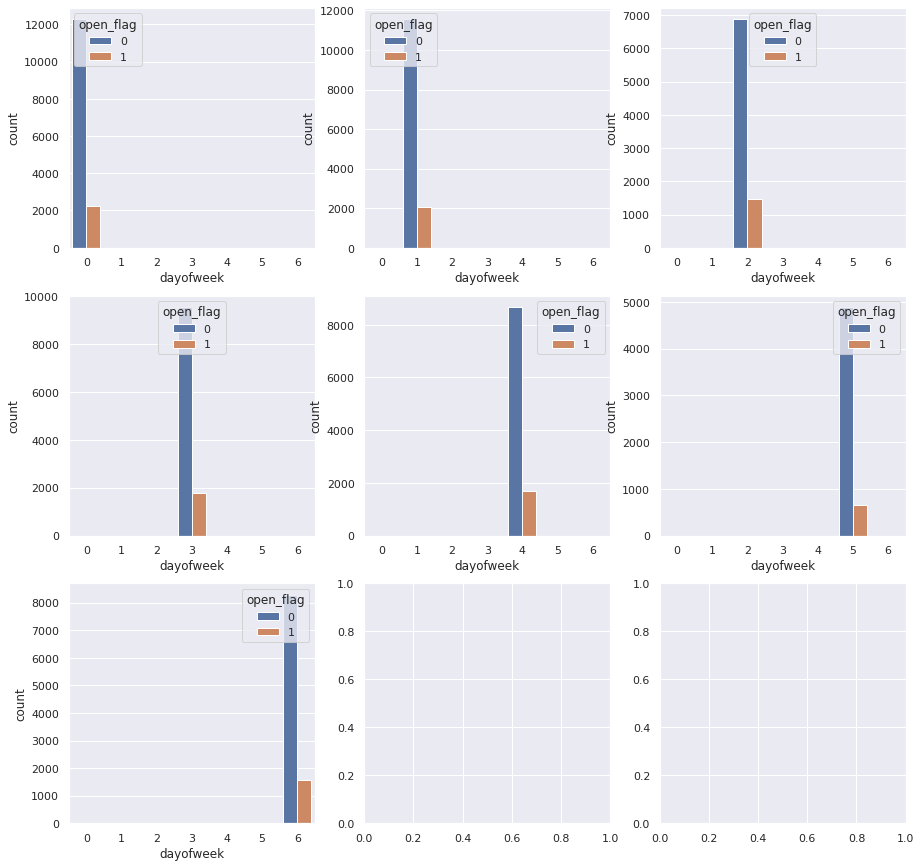

In [ ]:
fig, ax =plt.subplots(3,3, figsize=(15,15))

sb.countplot(data = train_categorical[train_categorical['dayofweek']==0], x = 'dayofweek', hue = 'open_flag', ax = ax[0,0])
sb.countplot(data = train_categorical[train_categorical['dayofweek']==1], x = 'dayofweek', hue = 'open_flag', ax = ax[0,1])
sb.countplot(data = train_categorical[train_categorical['dayofweek']==2], x = 'dayofweek', hue = 'open_flag', ax = ax[0,2])
sb.countplot(data = train_categorical[train_categorical['dayofweek']==3], x = 'dayofweek', hue = 'open_flag', ax = ax[1,0])
sb.countplot(data = train_categorical[train_categorical['dayofweek']==4], x = 'dayofweek', hue = 'open_flag', ax = ax[1,1])
sb.countplot(data = train_categorical[train_categorical['dayofweek']==5], x = 'dayofweek', hue = 'open_flag', ax = ax[1,2])
sb.countplot(data = train_categorical[train_categorical['dayofweek']==6], x = 'dayofweek', hue = 'open_flag', ax = ax[2,0])

plt.show()

##### month

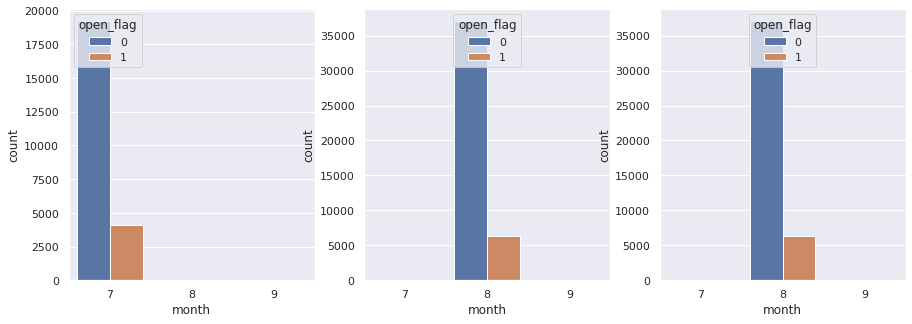

In [ ]:
fig, ax =plt.subplots(1,3, figsize=(15,5))

sb.countplot(data = train_categorical[train_categorical['month']==7], x = 'month', hue = 'open_flag', ax = ax[0])
sb.countplot(data = train_categorical[train_categorical['month']==8], x = 'month', hue = 'open_flag', ax = ax[1])
sb.countplot(data = train_categorical[train_categorical['month']==8], x = 'month', hue = 'open_flag', ax = ax[2])

plt.show()

##### country_code

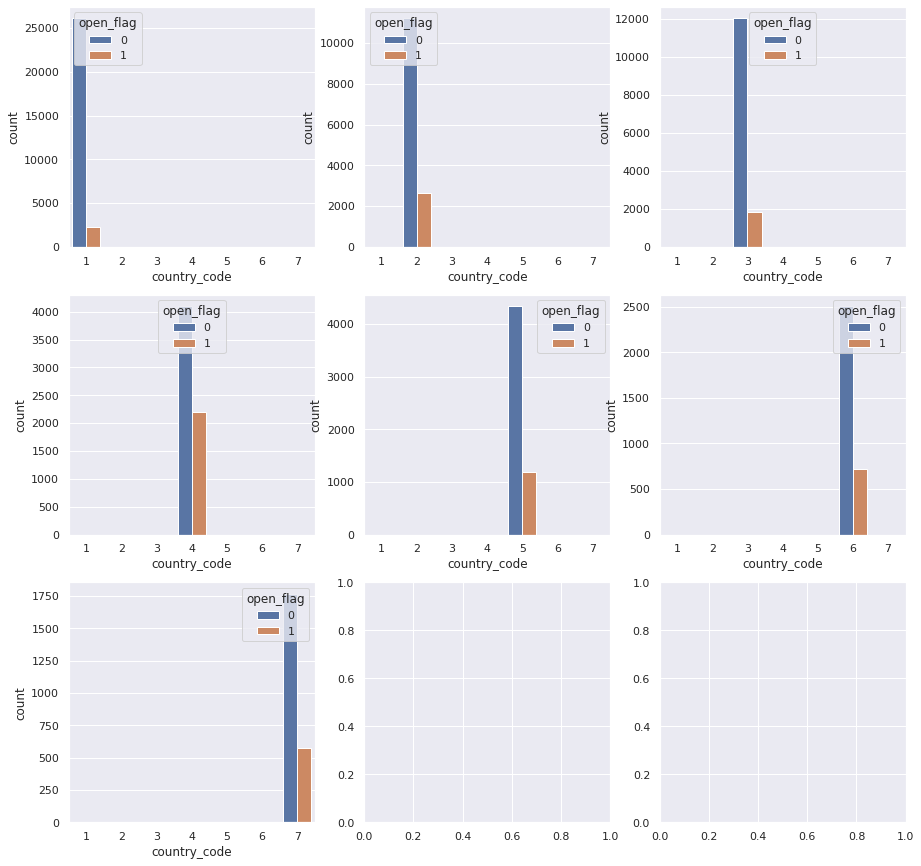

In [ ]:
fig, ax =plt.subplots(3,3, figsize=(15,15))

sb.countplot(data = train_categorical[train_categorical['country_code']==1], x = 'country_code', hue = 'open_flag', ax = ax[0,0])
sb.countplot(data = train_categorical[train_categorical['country_code']==2], x = 'country_code', hue = 'open_flag', ax = ax[0,1])
sb.countplot(data = train_categorical[train_categorical['country_code']==3], x = 'country_code', hue = 'open_flag', ax = ax[0,2])
sb.countplot(data = train_categorical[train_categorical['country_code']==4], x = 'country_code', hue = 'open_flag', ax = ax[1,0])
sb.countplot(data = train_categorical[train_categorical['country_code']==5], x = 'country_code', hue = 'open_flag', ax = ax[1,1])
sb.countplot(data = train_categorical[train_categorical['country_code']==6], x = 'country_code', hue = 'open_flag', ax = ax[1,2])
sb.countplot(data = train_categorical[train_categorical['country_code']==7], x = 'country_code', hue = 'open_flag', ax = ax[2,0])

plt.show()

##### attr_1

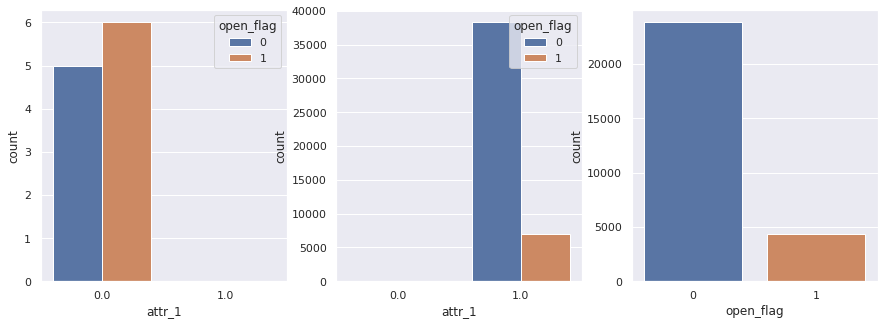

In [ ]:
fig, ax =plt.subplots(1,3, figsize=(15,5))

sb.countplot(data = train_categorical[train_categorical['attr_1']==0], x = 'attr_1', hue = 'open_flag', ax = ax[0])
sb.countplot(data = train_categorical[train_categorical['attr_1']==1], x = 'attr_1', hue = 'open_flag', ax = ax[1])
sb.countplot(data = train_categorical[train_categorical['attr_1'].isna()], x = 'open_flag', ax = ax[2])

plt.show()

## ['country_code', 'attr_1', 'attr_2', 'attr_3', 'domain', 'open_flag']

##### attr_2

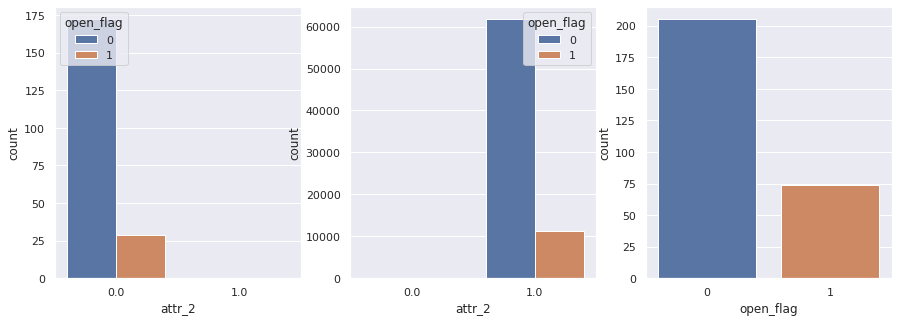

In [ ]:
fig, ax =plt.subplots(1,3, figsize=(15,5))

sb.countplot(data = train_categorical[train_categorical['attr_2']==0], x = 'attr_2', hue = 'open_flag', ax = ax[0])
sb.countplot(data = train_categorical[train_categorical['attr_2']==1], x = 'attr_2', hue = 'open_flag', ax = ax[1])
sb.countplot(data = train_categorical[train_categorical['attr_2'].isna()], x = 'open_flag', ax = ax[2])

plt.show()

##### attr_3

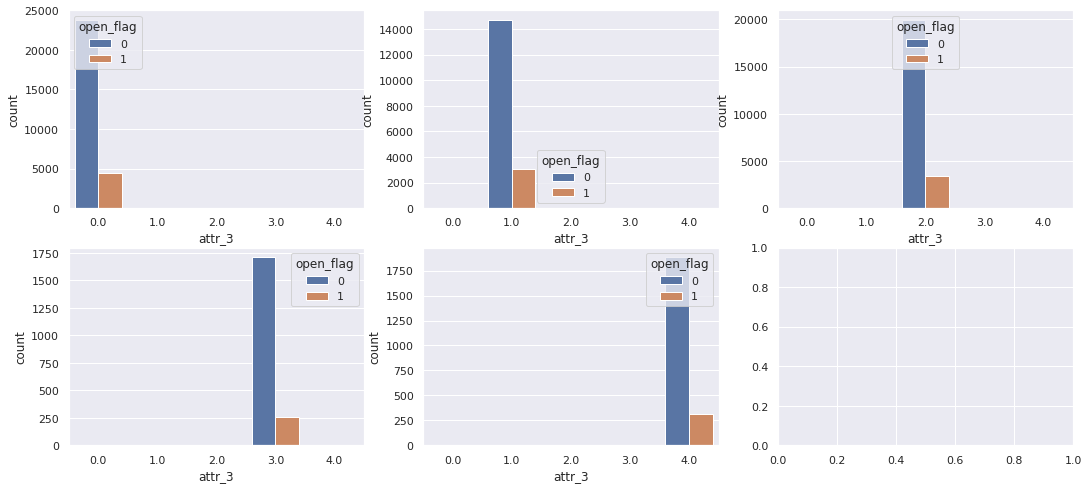

In [ ]:
fig, ax =plt.subplots(2,3, figsize=(18,8))

sb.countplot(data = train_categorical[train_categorical['attr_3']==0], x = 'attr_3', hue = 'open_flag', ax = ax[0, 0])
sb.countplot(data = train_categorical[train_categorical['attr_3']==1], x = 'attr_3', hue = 'open_flag', ax = ax[0, 1])
sb.countplot(data = train_categorical[train_categorical['attr_3']==2], x = 'attr_3', hue = 'open_flag', ax = ax[0, 2])
sb.countplot(data = train_categorical[train_categorical['attr_3']==3], x = 'attr_3', hue = 'open_flag', ax = ax[1, 0])
sb.countplot(data = train_categorical[train_categorical['attr_3']==4], x = 'attr_3', hue = 'open_flag', ax = ax[1, 1])

plt.show()

##### domain

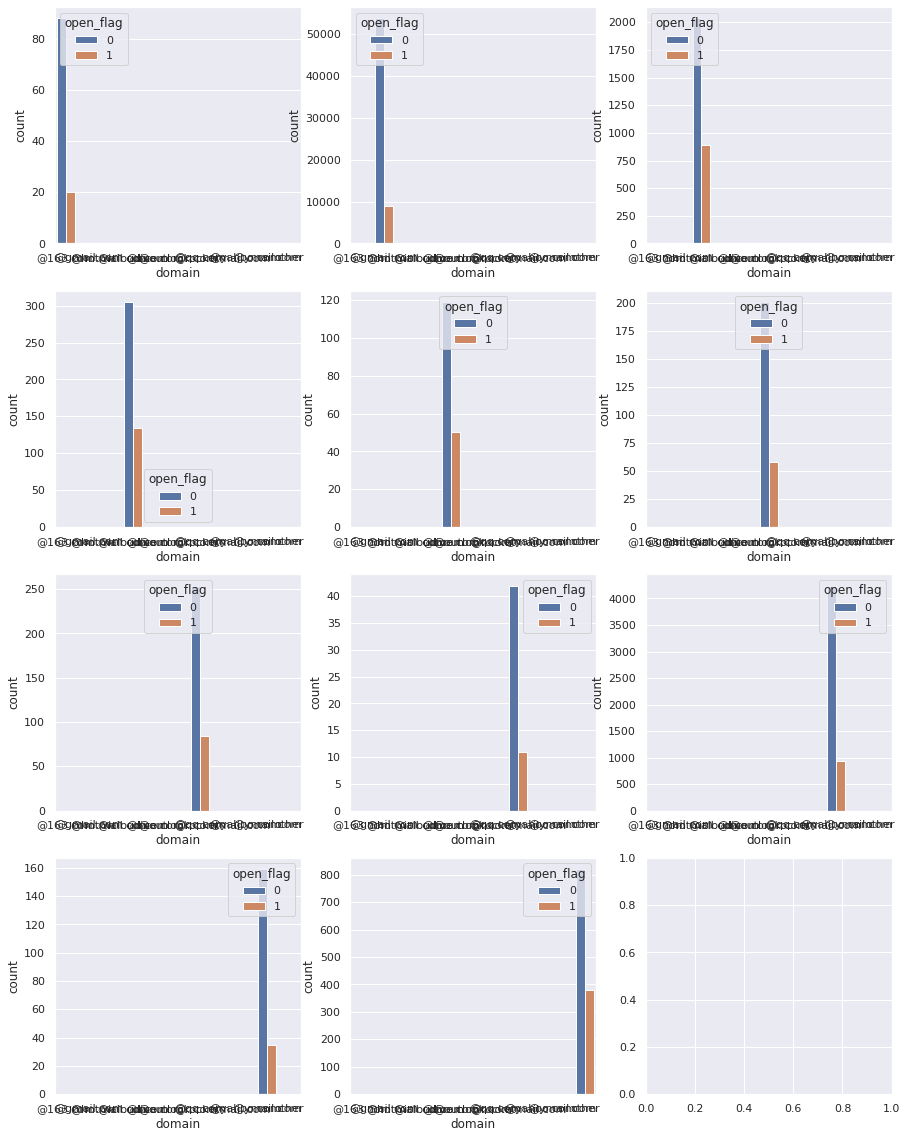

In [ ]:
fig, ax =plt.subplots(4,3, figsize=(15,20))

sb.countplot(data = train_categorical[train_categorical['domain']=='@163.com'], x = 'domain', hue = 'open_flag', ax = ax[0, 0])
sb.countplot(data = train_categorical[train_categorical['domain']=='@gmail.com'], x = 'domain', hue = 'open_flag', ax = ax[0, 1])
sb.countplot(data = train_categorical[train_categorical['domain']=='@hotmail.com'], x = 'domain', hue = 'open_flag', ax = ax[0, 2])
sb.countplot(data = train_categorical[train_categorical['domain']=='@icloud.com'], x = 'domain', hue = 'open_flag', ax = ax[1, 0])
sb.countplot(data = train_categorical[train_categorical['domain']=='@live.com'], x = 'domain', hue = 'open_flag', ax = ax[1, 1])
sb.countplot(data = train_categorical[train_categorical['domain']=='@outlook.com'], x = 'domain', hue = 'open_flag', ax = ax[1, 2])
sb.countplot(data = train_categorical[train_categorical['domain']=='@qq.com'], x = 'domain', hue = 'open_flag', ax = ax[2, 0])
sb.countplot(data = train_categorical[train_categorical['domain']=='@rocketmail.com'], x = 'domain', hue = 'open_flag', ax = ax[2, 1])
sb.countplot(data = train_categorical[train_categorical['domain']=='@yahoo.com'], x = 'domain', hue = 'open_flag', ax = ax[2, 2])
sb.countplot(data = train_categorical[train_categorical['domain']=='@ymail.com'], x = 'domain', hue = 'open_flag', ax = ax[3, 0])
sb.countplot(data = train_categorical[train_categorical['domain']=='other'], x = 'domain', hue = 'open_flag', ax = ax[3, 1])


plt.show()

In [ ]:
train_categorical['domain'].describe()

count          73539
unique            11
top       @gmail.com
freq           62670
Name: domain, dtype: object

## Data Preprocessing

#### Numeric only

In [ ]:
train_numeric['age'].mean()

31.445564204908813

In [ ]:
train_numeric['age'] = train_numeric['age'].fillna(train_numeric['age'].mean())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
train_numeric.isna().sum()

user_id                        0
subject_line_length            0
open_count_last_10_days        0
open_count_last_30_days        0
open_count_last_60_days        0
login_count_last_10_days       0
login_count_last_30_days       0
login_count_last_60_days       0
checkout_count_last_10_days    0
checkout_count_last_30_days    0
checkout_count_last_60_days    0
age                            0
open_flag                      0
dtype: int64

In [ ]:
train_numeric = train_numeric.sample(frac=1).reset_index(drop=True)
train_numeric.head()

,user_id,subject_line_length,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,age,open_flag
0,108973,37,5,8,11,0,0,2,0,0,0,31.445564,0
1,42628,37,0,0,1,9,29,34,0,1,1,16.000000,0
2,40380,29,0,1,1,5,24,44,0,2,2,29.000000,0
3,22695,32,1,1,1,1,11,14,0,2,2,31.445564,0
4,10857,36,0,0,1,10,27,55,2,5,10,37.000000,0


In [ ]:
train_numeric = pd.concat([train_numeric[train_numeric['open_flag']==0].iloc[:11456], train_numeric[train_numeric['open_flag']==1]], axis=0, ignore_index=True)

In [ ]:
train_numeric = train_numeric.sample(frac=1).reset_index(drop=True)
train_numeric.head()

,user_id,subject_line_length,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,age,open_flag
0,76975,41,1,4,15,21,69,155,0,0,1,30.000000,1
1,103999,57,0,0,3,23,140,311,0,10,26,19.000000,0
2,34296,39,1,1,1,0,0,1,0,0,0,25.000000,1
3,92639,39,4,11,21,1,7,7,0,0,0,31.445564,1
4,73355,63,0,2,2,0,2,5,0,0,0,33.000000,0


In [ ]:
## WITHOUT AGE
trainset = train_numeric[['subject_line_length', 'open_count_last_10_days', 'open_count_last_30_days', 'open_count_last_60_days', 'login_count_last_10_days', 'login_count_last_30_days', 'login_count_last_60_days', 'checkout_count_last_10_days', 'checkout_count_last_30_days', 'checkout_count_last_60_days']]
trainset.head()

,subject_line_length,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days
0,41,1,4,15,21,69,155,0,0,1
1,57,0,0,3,23,140,311,0,10,26
2,39,1,1,1,0,0,1,0,0,0
3,39,4,11,21,1,7,7,0,0,0
4,63,0,2,2,0,2,5,0,0,0


In [ ]:
normalized_df=(trainset-trainset.min())/(trainset.max()-trainset.min())
normalized_df.head()

,subject_line_length,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days
0,0.476923,0.032258,0.043478,0.111111,0.097674,0.160465,0.179606,0.0,0.000000,0.001658
1,0.723077,0.000000,0.000000,0.022222,0.106977,0.325581,0.360371,0.0,0.035587,0.043118
2,0.446154,0.032258,0.010870,0.007407,0.000000,0.000000,0.001159,0.0,0.000000,0.000000
3,0.446154,0.129032,0.119565,0.155556,0.004651,0.016279,0.008111,0.0,0.000000,0.000000
4,0.815385,0.000000,0.021739,0.014815,0.000000,0.004651,0.005794,0.0,0.000000,0.000000


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(normalized_df, train_numeric['open_flag'], test_size=0.1, random_state=2020)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20620, 11), (2292, 11), (20620,), (2292,))

In [ ]:
train_numeric.groupby('open_flag').agg('count')

,user_id,subject_line_length,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,age
open_flag,,,,,,,,,,,,
0,11456,11456,11456,11456,11456,11456,11456,11456,11456,11456,11456,11456
1,11456,11456,11456,11456,11456,11456,11456,11456,11456,11456,11456,11456


In [ ]:
# y_train = to_categorical(y_train, 2)
# y_test = to_categorical(y_test, 2)
# y_train[0:5]

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20620, 11), (2292, 11), (20620,), (2292,))

#### Categorical only

In [ ]:
train_categorical['attr_1'] = train_categorical['attr_1'].astype(float)
train_categorical['attr_1'] = train_categorical['attr_1'].fillna(2.0)
train_categorical['attr_1'] = train_categorical['attr_1'].astype('category')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
train_categorical['attr_2'] = train_categorical['attr_2'].astype(float)
train_categorical['attr_2'] = train_categorical['attr_2'].fillna(0.0)
train_categorical['attr_2'] = train_categorical['attr_2'].astype('category')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
# train_categorical = train_categorical.dropna()

In [ ]:
train_categorical.isna().sum()

user_id         0
country_code    0
attr_1          0
attr_2          0
attr_3          0
domain          0
open_flag       0
dtype: int64

In [ ]:
train_categorical.groupby('open_flag').agg('count')

,user_id,country_code,attr_1,attr_2,attr_3,domain
open_flag,,,,,,
0,62083,62083,62083,62083,62083,62083
1,11456,11456,11456,11456,11456,11456


In [ ]:
train_categorical = train_categorical.sample(frac=1).reset_index(drop=True)
train_categorical.head()

,user_id,country_code,attr_1,attr_2,attr_3,domain,open_flag
0,5468,6,2.0,1.0,0.0,@gmail.com,0
1,56756,3,2.0,1.0,0.0,@yahoo.com,0
2,117186,1,1.0,1.0,2.0,@gmail.com,0
3,86665,2,1.0,1.0,1.0,@gmail.com,0
4,87444,6,2.0,1.0,0.0,@gmail.com,0


In [ ]:
train_categorical = pd.concat([train_categorical[train_categorical['open_flag']==0].iloc[:11456], train_categorical[train_categorical['open_flag']==1]], axis=0, ignore_index=True)

In [ ]:
train_categorical.groupby('open_flag').agg('count')

,user_id,country_code,attr_1,attr_2,attr_3,domain
open_flag,,,,,,
0,11456,11456,11456,11456,11456,11456
1,11456,11456,11456,11456,11456,11456


In [ ]:
train_categorical = train_categorical.sample(frac=1).reset_index(drop=True)
train_categorical.head()

,user_id,country_code,attr_1,attr_2,attr_3,domain,open_flag
0,45254,3,1.0,1.0,2.0,@gmail.com,1
1,20862,5,1.0,1.0,1.0,@gmail.com,1
2,6910,5,1.0,1.0,2.0,@gmail.com,0
3,22593,5,1.0,1.0,2.0,@gmail.com,1
4,31002,1,1.0,1.0,1.0,@gmail.com,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_categorical.loc[:,'country_code':'attr_3'], train_categorical['open_flag'], test_size=0.3, random_state=2020)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16038, 4), (6874, 4), (16038,), (6874,))

In [ ]:
X_train = to_categorical(X_train)
X_test = to_categorical(X_test)
X_train[0:5]

array([[[0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.]],

       [[0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.]]], dtype=float32)

In [ ]:
X_train.shape, X_test.shape

((16038, 4, 8), (6874, 4, 8))

In [ ]:
# y_train = to_categorical(y_train, 2)
# y_test = to_categorical(y_test, 2)
y_train[0:5]

13836    1
7391     1
20126    1
22423    0
17452    1
Name: open_flag, dtype: category
Categories (2, int64): [0, 1]

In [ ]:
y_train.shape

(16038,)

#### Combined

In [ ]:
# agemean = train_comb['age'].mean()
agemed = train_comb['age'].median()

In [ ]:
train_comb[train_comb['age']<0]#.groupby('open_flag').agg('count')

,country_code,grass_date,user_id,subject_line_length,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,open_flag,row_id,hour,dayofweek,month,attr_2,attr_3,age,domain
55774,3,2019-08-22 00:00:00+08:00,86151,52,0,0,0,0,0,0,0,0,0,0,55774,0,3,8,1.0,3.0,-17.0,@gmail.com
59683,5,2019-08-26 00:00:00+08:00,1973,31,0,0,7,8,25,28,1,4,5,0,59683,0,0,8,1.0,2.0,-16.0,@gmail.com


In [ ]:
train_comb['age'] = train_comb['age'].fillna(-1)

In [ ]:
train_comb.drop(train_comb[train_comb['age']<-1].index, axis=0, inplace=True)

In [ ]:
train_comb[train_comb['age']<-1]

,country_code,grass_date,user_id,subject_line_length,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,open_flag,row_id,hour,dayofweek,month,attr_2,attr_3,age,domain


In [ ]:
train_comb['attr_1'] = train_comb['attr_1'].astype(float)
train_comb['attr_1'] = train_comb['attr_1'].fillna(2.0)
train_comb['attr_1'] = train_comb['attr_1'].astype('category')

In [ ]:
train_comb.groupby('attr_1').agg('count')

,country_code,grass_date,user_id,subject_line_length,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,open_flag,row_id,hour,dayofweek,month,attr_2,attr_3,age,domain
attr_1,,,,,,,,,,,,,,,,,,,,,,
0.0,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
1.0,45334,45334,45334,45334,45334,45334,45334,45334,45334,45334,45334,45334,45334,45334,45334,45334,45334,45334,45151,45334,45334,45334
2.0,28192,28192,28192,28192,28192,28192,28192,28192,28192,28192,28192,28192,28192,28192,28192,28192,28192,28192,28096,28192,28192,28192


In [ ]:
train_comb.isna().sum()

country_code                     0
grass_date                       0
user_id                          0
subject_line_length              0
open_count_last_10_days          0
open_count_last_30_days          0
open_count_last_60_days          0
login_count_last_10_days         0
login_count_last_30_days         0
login_count_last_60_days         0
checkout_count_last_10_days      0
checkout_count_last_30_days      0
checkout_count_last_60_days      0
open_flag                        0
row_id                           0
hour                             0
dayofweek                        0
month                            0
attr_2                         279
attr_3                           0
age                              0
domain                           0
dtype: int64

In [ ]:
train_comb = train_comb.dropna(axis=0)
len(train_comb)

73258

In [ ]:
train_comb = train_comb.sample(frac=1).reset_index(drop=True)
train_comb.head()

,country_code,grass_date,user_id,subject_line_length,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,open_flag,row_id,hour,dayofweek,month,attr_2,attr_3,age,domain
0,4,2019-08-03 00:00:00+08:00,79361,36,0,0,0,0,0,0,0,0,0,0,26114,0,5,8,1.0,0.0,-1.0,@gmail.com
1,4,2019-08-17 00:00:00+08:00,36190,45,0,0,0,10,55,99,0,1,3,0,47485,0,5,8,1.0,2.0,40.0,@hotmail.com
2,2,2019-07-27 00:00:00+08:00,90906,39,1,6,12,0,10,15,0,0,0,0,17089,0,5,7,1.0,2.0,22.0,@gmail.com
3,3,2019-08-11 00:00:00+08:00,27388,37,0,1,1,18,53,120,1,6,12,0,39073,0,6,8,1.0,2.0,24.0,@gmail.com
4,1,2019-08-15 00:00:00+08:00,56235,59,1,1,2,0,7,29,0,1,3,0,44221,0,3,8,1.0,1.0,33.0,@gmail.com


In [ ]:
len(train_comb)

73258

In [ ]:
train_comb = pd.concat([train_comb[train_comb['open_flag']==0].iloc[:11456], train_comb[train_comb['open_flag']==1]], axis=0, ignore_index=True)

In [ ]:
train_comb = train_comb.sample(frac=1).reset_index(drop=True)
train_comb.head()

,country_code,grass_date,user_id,subject_line_length,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,open_flag,row_id,hour,dayofweek,month,attr_2,attr_3,age,domain
0,1,2019-07-16 00:00:00+08:00,96840,58,3,10,13,31,86,184,1,1,2,1,1877,0,1,7,1.0,2.0,45.0,@gmail.com
1,3,2019-07-23 00:00:00+08:00,52433,52,0,0,0,6,14,22,0,0,0,1,10522,0,1,7,1.0,2.0,20.0,@gmail.com
2,3,2019-07-25 00:00:00+08:00,104494,53,0,1,2,0,0,0,0,0,0,0,15070,0,3,7,1.0,0.0,-1.0,@gmail.com
3,3,2019-08-06 00:00:00+08:00,57672,40,3,5,6,10,30,62,5,16,28,0,31360,0,1,8,1.0,2.0,31.0,@gmail.com
4,3,2019-07-30 00:00:00+08:00,102504,64,2,2,5,0,0,0,0,0,0,1,22824,0,1,7,1.0,4.0,19.0,@gmail.com


In [ ]:
## CHECK FOR AGE
trainnum = train_comb[['subject_line_length', 'open_count_last_10_days', 'open_count_last_30_days', 'open_count_last_60_days', 'login_count_last_10_days', 'login_count_last_30_days', 'login_count_last_60_days', 'checkout_count_last_10_days', 'checkout_count_last_30_days', 'checkout_count_last_60_days', 'age']]
trainnum.head()

,subject_line_length,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,age
0,58,3,10,13,31,86,184,1,1,2,45.0
1,52,0,0,0,6,14,22,0,0,0,20.0
2,53,0,1,2,0,0,0,0,0,0,-1.0
3,40,3,5,6,10,30,62,5,16,28,31.0
4,64,2,2,5,0,0,0,0,0,0,19.0


In [ ]:
normalized_df=(trainnum-trainnum.min())/(trainnum.max()-trainnum.min())
normalized_df.head()

,subject_line_length,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,age
0,0.738462,0.096774,0.108696,0.096296,0.145540,0.146508,0.162688,0.008475,0.003559,0.003317,0.386555
1,0.646154,0.000000,0.000000,0.000000,0.028169,0.023850,0.019452,0.000000,0.000000,0.000000,0.176471
2,0.661538,0.000000,0.010870,0.014815,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.461538,0.096774,0.054348,0.044444,0.046948,0.051107,0.054819,0.042373,0.056940,0.046434,0.268908
4,0.830769,0.064516,0.021739,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.168067


In [ ]:
traincat = train_comb[['country_code', 'attr_2', 'attr_3', 'domain']]
traincat.head()

,country_code,attr_2,attr_3,domain
0,1,1.0,2.0,@gmail.com
1,3,1.0,2.0,@gmail.com
2,3,1.0,0.0,@gmail.com
3,3,1.0,2.0,@gmail.com
4,3,1.0,4.0,@gmail.com


In [ ]:
# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
traincat['country_code'] = labelencoder.fit_transform(traincat['country_code'])
# traincat['attr_1'] = labelencoder.fit_transform(traincat['attr_1'])
traincat['attr_2'] = labelencoder.fit_transform(traincat['attr_2'])
traincat['attr_3'] = labelencoder.fit_transform(traincat['attr_3'])
traincat['domain'] = labelencoder.fit_transform(traincat['domain'])
# traincat.head()

# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')

enc_df = pd.DataFrame(enc.fit_transform(traincat[['country_code', 'attr_2', 'attr_3', 'domain']]).toarray())

enc_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
normalized_df = pd.concat([normalized_df.reset_index(drop=True), enc_df.reset_index(drop=True)], axis = 1)
normalized_df.head()

,subject_line_length,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,age,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.738462,0.096774,0.108696,0.096296,0.145540,0.146508,0.162688,0.008475,0.003559,0.003317,0.386555,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.646154,0.000000,0.000000,0.000000,0.028169,0.023850,0.019452,0.000000,0.000000,0.000000,0.176471,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.661538,0.000000,0.010870,0.014815,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.461538,0.096774,0.054348,0.044444,0.046948,0.051107,0.054819,0.042373,0.056940,0.046434,0.268908,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.830769,0.064516,0.021739,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.168067,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
normalized_df.shape

(22838, 36)

In [ ]:
train_comb.shape

(22838, 22)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(normalized_df, train_comb['open_flag'], test_size=0.1, random_state=2020)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20554, 36), (2284, 36), (20554,), (2284,))

In [ ]:
train_comb.groupby('open_flag').agg('count')

,country_code,grass_date,user_id,subject_line_length,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,row_id,hour,dayofweek,month,attr_2,attr_3,age,domain
open_flag,,,,,,,,,,,,,,,,,,,,,
0,11456,11456,11456,11456,11456,11456,11456,11456,11456,11456,11456,11456,11456,11456,11456,11456,11456,11456,11456,11456,11456
1,11382,11382,11382,11382,11382,11382,11382,11382,11382,11382,11382,11382,11382,11382,11382,11382,11382,11382,11382,11382,11382


In [ ]:
# y_train = to_categorical(y_train, 2)
# y_test = to_categorical(y_test, 2)
# y_train[0:5]

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20554, 36), (2284, 36), (20554,), (2284,))

## Data Pipeline

In [ ]:
# X_train = X_train.reshape(len(X_train), 32)
# X_test = X_test.reshape(len(X_test), 32)
X_train[:5]

,subject_line_length,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,age,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
20154,0.430769,0.032258,0.065217,0.066667,0.213953,0.207113,0.190035,0.067797,0.046263,0.051410,0.175000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14858,0.600000,0.322581,0.304348,0.400000,0.065116,0.100418,0.118192,0.000000,0.000000,0.000000,0.266667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10154,0.353846,0.096774,0.119565,0.081481,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19202,0.723077,0.000000,0.010870,0.014815,0.004651,0.033473,0.049826,0.000000,0.003559,0.014925,0.183333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22036,0.769231,0.000000,0.000000,0.007407,0.009302,0.027197,0.024334,0.000000,0.003559,0.003317,0.275000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_train.shape, y_train.shape

((20554, 36), (20554,))

In [ ]:
y_train[:20]

20154    0
14858    1
10154    1
19202    0
22036    1
4111     1
63       0
18185    0
21609    1
3440     1
10394    0
18637    1
13154    1
22334    1
22228    0
8694     1
3564     0
1498     1
12209    1
16780    1
Name: open_flag, dtype: category
Categories (2, int64): [0, 1]

In [ ]:
batch_size = 32 #* strategy.num_replicas_in_sync

In [ ]:
# For tf.dataset
# AUTO = tf.data.experimental.AUTOTUNE


train_dataset = tf.data.Dataset.from_tensor_slices((X_train, 
                                                    tf.cast(y_train, tf.float32)))
train_dataset = train_dataset.shuffle(20554)
train_dataset = train_dataset.repeat()
# train_dataset = train_dataset.cache()
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

In [ ]:
train_dataset

<BatchDataset shapes: ((32, 36), (32,)), types: (tf.float64, tf.float32)>

In [ ]:
valid_dataset = tf.data.Dataset.from_tensor_slices((X_test, 
                                                    tf.cast(y_test, tf.float32)))
valid_dataset = valid_dataset.repeat()
# valid_dataset = valid_dataset.cache()
valid_dataset = valid_dataset.batch(batch_size, drop_remainder=True)

In [ ]:
valid_dataset

<BatchDataset shapes: ((32, 36), (32,)), types: (tf.float64, tf.float32)>

## Modelling

In [ ]:
X_train.shape[-1]

36

In [ ]:
learning_rate = 0.005
epochs = 500

input_dim = X_train.shape[-1]

# n_hidden_1 =  32 # 1st layer number of neurons
# n_hidden_2 = 48 # 2nd layer number of neurons
# n_hidden_3 = 32 # 3rd layer number of neurons

# |-Trial ID: dd46b6f6e097e874602345adab4607fb
# |-Score: 0.596031665802002
# |-Best step: 0
# Hyperparameters:
# |-Dense_1: 48
# |-Dense_2: 384
# |-Dense_3: 256
# |-Dense_4: 416
# |-final_layers: 2
# |-units_0: 32
# |-units_1: 64

n_hidden_1 =  48 # 1st layer number of neurons
n_hidden_2 = 128 # 2nd layer number of neurons
n_hidden_3 = 256 # 3rd layer number of neurons
n_hidden_4 = 32 # 4th layer number of neurons
n_hidden_5 = 32 # 5th layer number of neurons
n_hidden_6 = 32 # 6th layer number of neurons

n_classes = 1

In [ ]:
# with strategy.scope():
model = Sequential()
model.add(Dense(n_hidden_1,  input_shape=(input_dim,), name = "Dense_1"))
model.add(Activation('relu', name = "Relu1"))

model.add(Dense(n_hidden_2, name = "Dense_2"))
model.add(Activation('relu', name = "Relu2"))

model.add(Dense(n_hidden_3, name = "Dense_3"))
model.add(Activation('relu', name = "Relu3"))
# model.add(Dropout(0.2))

model.add(Dense(n_hidden_4, name = "Dense_4"))
model.add(Activation('relu', name = "Relu4"))
# model.add(Dropout(0.3))

# model.add(Dense(n_hidden_5, name = "Dense_5"))
# model.add(Activation('relu', name = "Relu5"))
# model.add(Dropout(0.2))

# model.add(Dense(n_hidden_6, name = "Dense_6"))
# model.add(Activation('relu', name = "Relu6"))

model.add(Dense(n_classes, name = "Output"))
model.add(Activation('sigmoid', name = "Sigmoid"))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_1 (Dense)              (None, 48)                1776      
_________________________________________________________________
Relu1 (Activation)           (None, 48)                0         
_________________________________________________________________
Dense_2 (Dense)              (None, 128)               6272      
_________________________________________________________________
Relu2 (Activation)           (None, 128)               0         
_________________________________________________________________
Dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
Relu3 (Activation)           (None, 256)               0         
_________________________________________________________________
Dense_4 (Dense)              (None, 32)               

In [ ]:
# if y_pred > threshold we predict true. 
# Sometimes we set this to something different to 0.5 if we have unbalanced categories

threshold = 0.5

@tf.function
def mcc_metric(y_true, y_pred):
    predicted = tf.cast(tf.greater(y_pred, threshold), tf.float32)
    true_pos = tf.math.count_nonzero(predicted * y_true)
    true_neg = tf.math.count_nonzero((predicted - 1) * (y_true - 1))
    false_pos = tf.math.count_nonzero(predicted * (y_true - 1))
    false_neg = tf.math.count_nonzero((predicted - 1) * y_true)
    x = tf.cast((true_pos + false_pos) * (true_pos + false_neg) * (true_neg + false_pos) * (true_neg + false_neg), tf.float32)
    y = tf.cast((true_pos * true_neg) - (false_pos * false_neg), tf.float32)
    if x == 0:
        return tf.cast(0, tf.float32)
    else:
        return y / tf.sqrt(x)


In [ ]:
# with strategy.scope():
model.compile(loss='binary_crossentropy',
            optimizer= SGD(lr = learning_rate),
            metrics=['accuracy', mcc_metric])

##### Using keras-tuner

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('Dense_1', 
                                 min_value=48,
                                 max_value=64,
                                 step=16),  
                    input_shape=(input_dim,)))
    model.add(Dense(units=hp.Int('Dense_2',
                                 min_value=64,
                                 max_value=256,
                                 step=32),
                    activation='relu'))
    model.add(Dense(units=hp.Int('Dense_3',
                                 min_value=256,
                                 max_value=512,
                                 step=32),
                    activation='relu'))
    model.add(Dense(units=hp.Int('Dense_4',
                                 min_value=256,
                                 max_value=512,
                                 step=32),
                    activation='relu'))
    for i in range(hp.Int('final_layers', 1, 2)):
        model.add(Dense(units=hp.Int('units_' + str(i),
                                        min_value=32,
                                        max_value=64,
                                        step=32),
                               activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=SGD(lr = 4e-3, momentum = 0.1),
        loss='binary_crossentropy',
        metrics=['accuracy', mcc_metric])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective = kerastuner.Objective("val_mcc_metric", direction="max"),
    max_trials=160,
    executions_per_trial=3,
    directory='.',
    project_name='combdata_tpu',
    distribution_strategy=strategy)

In [ ]:
tuner.search_space_summary()

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor = "val_mcc_metric",
        mode = 'max',
        min_delta=2e-4,
        patience=10,
        verbose=1
        ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'val_mcc_metric', 
        mode = 'max', 
        factor = 0.9, 
        patience = 2, 
        cooldown = 1, 
        min_lr = 0.00001)
]

In [ ]:
tuner.search(train_dataset,
             epochs=500,
             steps_per_epoch = train_steps,
             validation_steps = val_steps,
             verbose = 2,
             callbacks = callbacks,
             validation_data=valid_dataset)

Epoch 1/500


UnimplementedError: ignored

##### Search summary

In [ ]:
tuner.results_summary()

In [ ]:
tuner.results_summary()

In [ ]:
tuner.results_summary()

In [ ]:
models = tuner.get_best_models(num_models=2)

In [ ]:
models[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2368      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_2 (Dense)              (None, 160)               41120     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                5152      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 65,313
Trainable params: 65,313
Non-trainable params: 0
_________________________________________________________________


#### Training

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        # filepath="numdata_best_weights.hdf5",
        # filepath="catdata_best_weights.hdf5",
        filepath="combdata_best_weights_bestmodel.hdf5",
        save_best_only=True,  # Only save a model if `mcc` has improved.
        monitor="val_mcc_metric",
        mode = 'max',
        verbose=1,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_mcc_metric",
        mode = 'max',
        min_delta = 2e-4,
        patience = 12,
        verbose = 1
        ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'val_mcc_metric', 
        mode = 'max', 
        factor = 0.9, 
        patience = 2, 
        cooldown = 1, 
        min_lr = 0.00001)
]

In [ ]:
len(X_test)

2284

In [ ]:
# numdata
# train_steps = int(20620/batch_size) #total trains set / batch_size
# val_steps = int(2292/batch_size)

#catdata
# train_steps = int(16038/batch_size) #total trains set / batch_size
# val_steps = int(6874/batch_size)

#combdata
# train_steps = int(62271/batch_size) #total trains set / batch_size
# val_steps = int(10989/batch_size)
train_steps = int(20554/batch_size) #total trains set / batch_size
val_steps = int(2284/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)

train steps: 642
val steps: 71


##### cat

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    callbacks = callbacks)

Epoch 1/100
165/184 [=========================>....] - ETA: 0s - loss: 0.6982 - accuracy: 0.4929
Epoch 00001: val_loss improved from inf to 0.69477, saving model to catdata_best_weights.hdf5
184/184 [==============================] - 1s 3ms/step - loss: 0.6986 - accuracy: 0.4915 - val_loss: 0.6948 - val_accuracy: 0.4905 - lr: 0.0010
Epoch 2/100
173/184 [===========================>..] - ETA: 0s - loss: 0.6985 - accuracy: 0.4919
Epoch 00002: val_loss improved from 0.69477 to 0.69447, saving model to catdata_best_weights.hdf5
184/184 [==============================] - 0s 2ms/step - loss: 0.6985 - accuracy: 0.4924 - val_loss: 0.6945 - val_accuracy: 0.4905 - lr: 0.0010
Epoch 3/100
163/184 [=========================>....] - ETA: 0s - loss: 0.6971 - accuracy: 0.4931
Epoch 00003: val_loss improved from 0.69447 to 0.69419, saving model to catdata_best_weights.hdf5
184/184 [==============================] - 0s 2ms/step - loss: 0.6971 - accuracy: 0.4917 - val_loss: 0.6942 - val_accuracy: 0.4905 

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    callbacks = callbacks)

Epoch 1/100
134/161 [=======================>......] - ETA: 0s - loss: 0.6895 - accuracy: 0.5276
Epoch 00001: val_loss improved from inf to 0.68677, saving model to catdata_best_weights.hdf5
161/161 [==============================] - 1s 4ms/step - loss: 0.6897 - accuracy: 0.5272 - val_loss: 0.6868 - val_accuracy: 0.5265 - lr: 0.0010
Epoch 2/100
141/161 [=========================>....] - ETA: 0s - loss: 0.6905 - accuracy: 0.5245
Epoch 00002: val_loss improved from 0.68677 to 0.68628, saving model to catdata_best_weights.hdf5
161/161 [==============================] - 0s 2ms/step - loss: 0.6907 - accuracy: 0.5234 - val_loss: 0.6863 - val_accuracy: 0.5263 - lr: 0.0010
Epoch 3/100
161/161 [==============================] - ETA: 0s - loss: 0.6897 - accuracy: 0.5305
Epoch 00003: val_loss improved from 0.68628 to 0.68586, saving model to catdata_best_weights.hdf5
161/161 [==============================] - 0s 2ms/step - loss: 0.6897 - accuracy: 0.5305 - val_loss: 0.6859 - val_accuracy: 0.5263 

In [ ]:
history = model.fit(train_dataset,
                    epochs = epochs,
                    steps_per_epoch = train_steps,
                    verbose = 1,
                    validation_data = valid_dataset,
                    validation_steps = val_steps,
                    callbacks = callbacks)

Epoch 1/100
498/501 [============================>.] - ETA: 0s - loss: 0.7002 - accuracy: 0.4953 - mcc_metric: -0.0113
Epoch 00001: mcc_metric improved from -inf to -0.01079, saving model to catdata_best_weights.hdf5
501/501 [==============================] - 3s 5ms/step - loss: 0.7002 - accuracy: 0.4954 - mcc_metric: -0.0108 - val_loss: 0.6945 - val_accuracy: 0.4936 - val_mcc_metric: -0.0092 - lr: 0.0010
Epoch 2/100
492/501 [============================>.] - ETA: 0s - loss: 0.6978 - accuracy: 0.5022 - mcc_metric: 0.0055
Epoch 00002: mcc_metric improved from -0.01079 to 0.00653, saving model to catdata_best_weights.hdf5
501/501 [==============================] - 2s 5ms/step - loss: 0.6978 - accuracy: 0.5027 - mcc_metric: 0.0065 - val_loss: 0.6919 - val_accuracy: 0.5225 - val_mcc_metric: 0.0470 - lr: 0.0010
Epoch 3/100
499/501 [============================>.] - ETA: 0s - loss: 0.6950 - accuracy: 0.5082 - mcc_metric: 0.0156
Epoch 00003: mcc_metric improved from 0.00653 to 0.01584, saving

##### num

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    callbacks = callbacks)

Epoch 1/100
586/589 [============================>.] - ETA: 0s - loss: 0.8389 - accuracy: 0.7094
Epoch 00001: val_loss improved from inf to 0.68036, saving model to catdata_best_weights.hdf5
589/589 [==============================] - 1s 2ms/step - loss: 0.8381 - accuracy: 0.7096 - val_loss: 0.6804 - val_accuracy: 0.8480 - lr: 0.0010
Epoch 2/100
562/589 [===========================>..] - ETA: 0s - loss: 0.6493 - accuracy: 0.7758
Epoch 00002: val_loss improved from 0.68036 to 0.52343, saving model to catdata_best_weights.hdf5
589/589 [==============================] - 1s 2ms/step - loss: 0.6483 - accuracy: 0.7768 - val_loss: 0.5234 - val_accuracy: 0.8470 - lr: 0.0010
Epoch 3/100
574/589 [============================>.] - ETA: 0s - loss: 0.5757 - accuracy: 0.8141
Epoch 00003: val_loss improved from 0.52343 to 0.45307, saving model to catdata_best_weights.hdf5
589/589 [==============================] - 1s 2ms/step - loss: 0.5751 - accuracy: 0.8142 - val_loss: 0.4531 - val_accuracy: 0.8477 

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    callbacks = callbacks)

Epoch 1/100
907/920 [============================>.] - ETA: 0s - loss: 0.6821 - accuracy: 0.8088
Epoch 00001: val_loss improved from inf to 0.45216, saving model to catdata_best_weights.hdf5
920/920 [==============================] - 2s 2ms/step - loss: 0.6809 - accuracy: 0.8090 - val_loss: 0.4522 - val_accuracy: 0.8444 - lr: 0.0010
Epoch 2/100
898/920 [============================>.] - ETA: 0s - loss: 0.5003 - accuracy: 0.8381
Epoch 00002: val_loss improved from 0.45216 to 0.40268, saving model to catdata_best_weights.hdf5
920/920 [==============================] - 2s 2ms/step - loss: 0.4983 - accuracy: 0.8386 - val_loss: 0.4027 - val_accuracy: 0.8443 - lr: 0.0010
Epoch 3/100
901/920 [============================>.] - ETA: 0s - loss: 0.4333 - accuracy: 0.8441
Epoch 00003: val_loss improved from 0.40268 to 0.39518, saving model to catdata_best_weights.hdf5
920/920 [==============================] - 2s 2ms/step - loss: 0.4337 - accuracy: 0.8440 - val_loss: 0.3952 - val_accuracy: 0.8451 

In [ ]:
#After normalising
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    callbacks = callbacks)

Epoch 1/100
912/920 [============================>.] - ETA: 0s - loss: 0.6214 - accuracy: 0.8065
Epoch 00001: val_loss improved from inf to 0.55372, saving model to catdata_best_weights.hdf5
920/920 [==============================] - 2s 2ms/step - loss: 0.6209 - accuracy: 0.8068 - val_loss: 0.5537 - val_accuracy: 0.8434 - lr: 0.0010
Epoch 2/100
898/920 [============================>.] - ETA: 0s - loss: 0.5208 - accuracy: 0.8442
Epoch 00002: val_loss improved from 0.55372 to 0.47747, saving model to catdata_best_weights.hdf5
920/920 [==============================] - 2s 2ms/step - loss: 0.5199 - accuracy: 0.8444 - val_loss: 0.4775 - val_accuracy: 0.8434 - lr: 0.0010
Epoch 3/100
899/920 [============================>.] - ETA: 0s - loss: 0.4673 - accuracy: 0.8446
Epoch 00003: val_loss improved from 0.47747 to 0.44273, saving model to catdata_best_weights.hdf5
920/920 [==============================] - 2s 2ms/step - loss: 0.4673 - accuracy: 0.8444 - val_loss: 0.4427 - val_accuracy: 0.8434 

In [ ]:
history = model.fit(train_dataset,
                    epochs = epochs,
                    steps_per_epoch = train_steps,
                    verbose = 1,
                    validation_data = valid_dataset,
                    validation_steps = val_steps,
                    callbacks = callbacks)

Epoch 1/100
641/644 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5086
Epoch 00001: val_loss improved from inf to 0.69164, saving model to catdata_best_weights.hdf5
644/644 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.5089 - val_loss: 0.6916 - val_accuracy: 0.5273 - lr: 0.0010
Epoch 2/100
632/644 [============================>.] - ETA: 0s - loss: 0.6920 - accuracy: 0.5289
Epoch 00002: val_loss improved from 0.69164 to 0.69006, saving model to catdata_best_weights.hdf5
644/644 [==============================] - 1s 2ms/step - loss: 0.6919 - accuracy: 0.5290 - val_loss: 0.6901 - val_accuracy: 0.5986 - lr: 0.0010
Epoch 3/100
631/644 [============================>.] - ETA: 0s - loss: 0.6908 - accuracy: 0.5497
Epoch 00003: val_loss improved from 0.69006 to 0.68882, saving model to catdata_best_weights.hdf5
644/644 [==============================] - 1s 2ms/step - loss: 0.6908 - accuracy: 0.5504 - val_loss: 0.6888 - val_accuracy: 0.6967 

In [ ]:
history = model.fit(train_dataset,
                    epochs = epochs,
                    steps_per_epoch = train_steps,
                    verbose = 1,
                    validation_data = valid_dataset,
                    validation_steps = val_steps,
                    callbacks = callbacks)

Epoch 1/100
640/644 [============================>.] - ETA: 0s - loss: 0.6926 - accuracy: 0.5194 - mcc_metric: 0.0401
Epoch 00001: mcc_metric improved from -inf to 0.03992, saving model to catdata_best_weights.hdf5
644/644 [==============================] - 3s 5ms/step - loss: 0.6926 - accuracy: 0.5195 - mcc_metric: 0.0399 - val_loss: 0.6911 - val_accuracy: 0.5312 - val_mcc_metric: nan - lr: 0.0010
Epoch 2/100
638/644 [============================>.] - ETA: 0s - loss: 0.6908 - accuracy: 0.5411 - mcc_metric: 0.0852
Epoch 00002: mcc_metric improved from 0.03992 to 0.08402, saving model to catdata_best_weights.hdf5
644/644 [==============================] - 3s 4ms/step - loss: 0.6908 - accuracy: 0.5406 - mcc_metric: 0.0840 - val_loss: 0.6889 - val_accuracy: 0.6651 - val_mcc_metric: 0.3918 - lr: 0.0010
Epoch 3/100
635/644 [============================>.] - ETA: 0s - loss: 0.6892 - accuracy: 0.5552 - mcc_metric: 0.1120
Epoch 00003: mcc_metric improved from 0.08402 to 0.11311, saving model t

##### comb

In [ ]:
history = model.fit(train_dataset,
                    epochs = epochs,
                    steps_per_epoch = train_steps,
                    verbose = 1,
                    validation_data = valid_dataset,
                    validation_steps = val_steps,
                    callbacks = callbacks)

Epoch 1/500
642/642 [==============================] - ETA: 0s - loss: 0.6907 - accuracy: 0.5323 - mcc_metric: 0.0718
Epoch 00001: val_mcc_metric improved from -inf to 0.14764, saving model to combdata_best_weights_bestmodel.hdf5
642/642 [==============================] - 3s 5ms/step - loss: 0.6907 - accuracy: 0.5323 - mcc_metric: 0.0718 - val_loss: 0.6873 - val_accuracy: 0.5629 - val_mcc_metric: 0.1476
Epoch 2/500
633/642 [============================>.] - ETA: 0s - loss: 0.6820 - accuracy: 0.5858 - mcc_metric: 0.1761
Epoch 00002: val_mcc_metric improved from 0.14764 to 0.20591, saving model to combdata_best_weights_bestmodel.hdf5
642/642 [==============================] - 3s 4ms/step - loss: 0.6820 - accuracy: 0.5854 - mcc_metric: 0.1752 - val_loss: 0.6783 - val_accuracy: 0.6030 - val_mcc_metric: 0.2059
Epoch 3/500
642/642 [==============================] - ETA: 0s - loss: 0.6708 - accuracy: 0.6152 - mcc_metric: 0.2323
Epoch 00003: val_mcc_metric improved from 0.20591 to 0.25714, sav

In [ ]:
history = model.fit(train_dataset,
                    epochs = epochs,
                    steps_per_epoch = train_steps,
                    verbose = 1,
                    validation_data = valid_dataset,
                    validation_steps = val_steps,
                    callbacks = callbacks)

Epoch 1/500
640/642 [============================>.] - ETA: 0s - loss: 0.6881 - accuracy: 0.5679 - mcc_metric: 0.1511
Epoch 00001: val_mcc_metric improved from -inf to 0.24114, saving model to combdata_best_weights_bestmodel.hdf5
642/642 [==============================] - 2s 4ms/step - loss: 0.6881 - accuracy: 0.5682 - mcc_metric: 0.1516 - val_loss: 0.6815 - val_accuracy: 0.6109 - val_mcc_metric: 0.2411
Epoch 2/500
641/642 [============================>.] - ETA: 0s - loss: 0.6744 - accuracy: 0.6233 - mcc_metric: 0.2580
Epoch 00002: val_mcc_metric improved from 0.24114 to 0.29952, saving model to combdata_best_weights_bestmodel.hdf5
642/642 [==============================] - 2s 3ms/step - loss: 0.6744 - accuracy: 0.6232 - mcc_metric: 0.2580 - val_loss: 0.6664 - val_accuracy: 0.6413 - val_mcc_metric: 0.2995
Epoch 3/500
634/642 [============================>.] - ETA: 0s - loss: 0.6558 - accuracy: 0.6509 - mcc_metric: 0.3068
Epoch 00003: val_mcc_metric improved from 0.29952 to 0.33831, sav

##### Expts

In [ ]:
history = model.fit(train_dataset,
                    epochs = epochs,
                    steps_per_epoch = train_steps,
                    verbose = 1,
                    validation_data = valid_dataset,
                    validation_steps = val_steps,
                    callbacks = callbacks)

Epoch 1/500
635/642 [============================>.] - ETA: 0s - loss: 0.6919 - accuracy: 0.5229 - mcc_metric: 0.0463
Epoch 00001: val_mcc_metric improved from -inf to 0.13869, saving model to combdata_best_weights_bestmodel.hdf5
642/642 [==============================] - 5s 7ms/step - loss: 0.6919 - accuracy: 0.5229 - mcc_metric: 0.0465 - val_loss: 0.6900 - val_accuracy: 0.5687 - val_mcc_metric: 0.1387
Epoch 2/500
632/642 [============================>.] - ETA: 0s - loss: 0.6884 - accuracy: 0.5677 - mcc_metric: 0.1383
Epoch 00002: val_mcc_metric improved from 0.13869 to 0.17163, saving model to combdata_best_weights_bestmodel.hdf5
642/642 [==============================] - 3s 5ms/step - loss: 0.6884 - accuracy: 0.5677 - mcc_metric: 0.1382 - val_loss: 0.6848 - val_accuracy: 0.5854 - val_mcc_metric: 0.1716
Epoch 3/500
638/642 [============================>.] - ETA: 0s - loss: 0.6830 - accuracy: 0.5910 - mcc_metric: 0.1832
Epoch 00003: val_mcc_metric improved from 0.17163 to 0.20000, sav

In [ ]:
history = model.fit(train_dataset,
                    epochs = epochs,
                    steps_per_epoch = train_steps,
                    verbose = 1,
                    validation_data = valid_dataset,
                    validation_steps = val_steps,
                    callbacks = callbacks)

Epoch 1/500
635/642 [============================>.] - ETA: 0s - loss: 0.6973 - mcc_metric: -0.0257
Epoch 00001: val_mcc_metric improved from -inf to 0.07528, saving model to combdata_best_weights_testage.hdf5
642/642 [==============================] - 3s 4ms/step - loss: 0.6973 - mcc_metric: -0.0261 - val_loss: 0.6927 - val_mcc_metric: 0.0753
Epoch 2/500
632/642 [============================>.] - ETA: 0s - loss: 0.6944 - mcc_metric: 0.0135
Epoch 00002: val_mcc_metric improved from 0.07528 to 0.20663, saving model to combdata_best_weights_testage.hdf5
642/642 [==============================] - 3s 4ms/step - loss: 0.6943 - mcc_metric: 0.0140 - val_loss: 0.6897 - val_mcc_metric: 0.2066
Epoch 3/500
637/642 [============================>.] - ETA: 0s - loss: 0.6913 - mcc_metric: 0.0433
Epoch 00003: val_mcc_metric improved from 0.20663 to 0.24757, saving model to combdata_best_weights_testage.hdf5
642/642 [==============================] - 3s 4ms/step - loss: 0.6914 - mcc_metric: 0.0430 - va

In [ ]:
history = model.fit(train_dataset,
                    epochs = epochs,
                    steps_per_epoch = train_steps,
                    verbose = 1,
                    validation_data = valid_dataset,
                    validation_steps = val_steps,
                    callbacks = callbacks)

Epoch 1/500
636/642 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5113 - mcc_metric: 0.0233
Epoch 00001: val_mcc_metric improved from -inf to 0.17348, saving model to combdata_best_weights_testage.hdf5
642/642 [==============================] - 3s 5ms/step - loss: 0.6937 - accuracy: 0.5114 - mcc_metric: 0.0235 - val_loss: 0.6875 - val_accuracy: 0.5863 - val_mcc_metric: 0.1735
Epoch 2/500
634/642 [============================>.] - ETA: 0s - loss: 0.6893 - accuracy: 0.5343 - mcc_metric: 0.0693
Epoch 00002: val_mcc_metric improved from 0.17348 to 0.21673, saving model to combdata_best_weights_testage.hdf5
642/642 [==============================] - 3s 4ms/step - loss: 0.6893 - accuracy: 0.5348 - mcc_metric: 0.0701 - val_loss: 0.6827 - val_accuracy: 0.6087 - val_mcc_metric: 0.2167
Epoch 3/500
634/642 [============================>.] - ETA: 0s - loss: 0.6846 - accuracy: 0.5611 - mcc_metric: 0.1237
Epoch 00003: val_mcc_metric improved from 0.21673 to 0.22591, saving 

## Test set

In [ ]:
model.load_weights('./combdata_best_weights_bestmodel.hdf5')

In [ ]:
test_df.head()

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,row_id
0,6,2019-09-03 00:00:00+08:00,0,35,27,2,13,2,3,4,10,34,134,0,6,18,0
1,6,2019-09-03 00:00:00+08:00,130,35,7,5,383,1,1,1,5,5,5,0,0,0,1
2,5,2019-09-03 00:00:00+08:00,150,25,34,1,3,0,0,0,13,19,38,2,2,2,2
3,1,2019-09-03 00:00:00+08:00,181,36,63,5,5,0,0,0,43,110,173,2,5,5,3
4,5,2019-09-03 00:00:00+08:00,192,23,6,5,54,0,0,0,4,12,39,0,0,2,4


In [ ]:
test_comb = pd.merge(test_df, users_df, on = 'user_id', how = 'left')
print(len(test_comb))
test_comb.head()

55970


,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,row_id,attr_1,attr_2,attr_3,age,domain
0,6,2019-09-03 00:00:00+08:00,0,35,27,2,13,2,3,4,10,34,134,0,6,18,0,NaN,1.0,0.0,NaN,@gmail.com
1,6,2019-09-03 00:00:00+08:00,130,35,7,5,383,1,1,1,5,5,5,0,0,0,1,NaN,1.0,0.0,NaN,@gmail.com
2,5,2019-09-03 00:00:00+08:00,150,25,34,1,3,0,0,0,13,19,38,2,2,2,2,1.0,1.0,2.0,33.0,@gmail.com
3,1,2019-09-03 00:00:00+08:00,181,36,63,5,5,0,0,0,43,110,173,2,5,5,3,1.0,1.0,2.0,22.0,@yahoo.com
4,5,2019-09-03 00:00:00+08:00,192,23,6,5,54,0,0,0,4,12,39,0,0,2,4,NaN,1.0,0.0,NaN,@gmail.com


In [ ]:
test_comb[test_comb['age']<0]

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,row_id,attr_1,attr_2,attr_3,age,domain


In [ ]:
test_comb['age'] = test_comb['age'].fillna(120)

In [ ]:
test_comb.isna().sum()

country_code                       0
grass_date                         0
user_id                            0
subject_line_length                0
last_open_day                      0
last_login_day                     0
last_checkout_day                  0
open_count_last_10_days            0
open_count_last_30_days            0
open_count_last_60_days            0
login_count_last_10_days           0
login_count_last_30_days           0
login_count_last_60_days           0
checkout_count_last_10_days        0
checkout_count_last_30_days        0
checkout_count_last_60_days        0
row_id                             0
attr_1                         21233
attr_2                           168
attr_3                             0
age                                0
domain                             0
dtype: int64

In [ ]:
testnum = test_comb[['subject_line_length', 'open_count_last_10_days', 'open_count_last_30_days', 'open_count_last_60_days', 'login_count_last_10_days', 'login_count_last_30_days', 'login_count_last_60_days', 'checkout_count_last_10_days', 'checkout_count_last_30_days', 'checkout_count_last_60_days', 'age']]
testnum.head()

,subject_line_length,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,age
0,35,2,3,4,10,34,134,0,6,18,120.0
1,35,1,1,1,5,5,5,0,0,0,120.0
2,25,0,0,0,13,19,38,2,2,2,33.0
3,36,0,0,0,43,110,173,2,5,5,22.0
4,23,0,0,0,4,12,39,0,0,2,120.0


In [ ]:
testnum.describe()

,subject_line_length,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,age
count,55970.000000,55970.000000,55970.000000,55970.000000,55970.000000,55970.000000,55970.000000,55970.000000,55970.000000,55970.000000,55970.000000
mean,42.212703,0.774272,2.441880,5.323530,8.978899,26.289459,50.713882,1.124674,3.219385,5.933893,64.929355
std,12.276136,1.752984,4.786883,9.053473,13.975840,38.572656,73.289199,3.500704,8.197445,14.233715,43.968657
min,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,0.000000,0.000000,0.000000,0.000000,2.000000,4.000000,0.000000,0.000000,0.000000,27.000000
50%,41.000000,0.000000,0.000000,2.000000,4.000000,13.000000,25.000000,0.000000,1.000000,2.000000,38.000000
75%,48.000000,1.000000,3.000000,6.000000,13.000000,36.000000,70.000000,1.000000,3.000000,7.000000,120.000000
max,79.000000,30.000000,79.000000,120.000000,329.000000,746.000000,1300.000000,252.000000,404.000000,609.000000,120.000000


In [ ]:
trainnum.describe()

NameError: ignored

In [ ]:
normalized_df=(testnum-testnum.min())/(testnum.max()-testnum.min())
normalized_df.head()

,subject_line_length,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,age
0,0.352941,0.066667,0.037975,0.033333,0.030395,0.045576,0.103077,0.000000,0.014851,0.029557,1.000000
1,0.352941,0.033333,0.012658,0.008333,0.015198,0.006702,0.003846,0.000000,0.000000,0.000000,1.000000
2,0.205882,0.000000,0.000000,0.000000,0.039514,0.025469,0.029231,0.007937,0.004950,0.003284,0.275000
3,0.367647,0.000000,0.000000,0.000000,0.130699,0.147453,0.133077,0.007937,0.012376,0.008210,0.183333
4,0.176471,0.000000,0.000000,0.000000,0.012158,0.016086,0.030000,0.000000,0.000000,0.003284,1.000000


In [ ]:
testcat = test_comb[['country_code', 'attr_2', 'attr_3', 'domain']]
testcat.head()

,country_code,attr_2,attr_3,domain
0,6,1.0,0.0,@gmail.com
1,6,1.0,0.0,@gmail.com
2,5,1.0,2.0,@gmail.com
3,1,1.0,2.0,@yahoo.com
4,5,1.0,0.0,@gmail.com


In [ ]:
testcat.groupby('attr_1').agg('count')

In [ ]:
testcat.isna().sum()

country_code      0
attr_2          168
attr_3            0
domain            0
dtype: int64

In [ ]:
testcat['attr_2'] = testcat['attr_2'].astype(float)
testcat['attr_2'] = testcat['attr_2'].fillna(1.0)
testcat['attr_2'] = testcat['attr_2'].astype('category')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
testcat['attr_1'] = testcat['attr_1'].astype(float)
testcat['attr_1'] = testcat['attr_1'].fillna(2.0)
testcat['attr_1'] = testcat['attr_1'].astype('category')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
testcat.isna().sum()

country_code    0
attr_2          0
attr_3          0
domain          0
dtype: int64

In [ ]:
testcat.head()

,country_code,attr_2,attr_3,domain
0,6,1.0,0.0,@gmail.com
1,6,1.0,0.0,@gmail.com
2,5,1.0,2.0,@gmail.com
3,1,1.0,2.0,@yahoo.com
4,5,1.0,0.0,@gmail.com


In [ ]:
# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
testcat['country_code'] = labelencoder.fit_transform(testcat['country_code'])
# testcat['attr_1'] = labelencoder.fit_transform(testcat['attr_1'])
testcat['attr_2'] = labelencoder.fit_transform(testcat['attr_2'])
testcat['attr_3'] = labelencoder.fit_transform(testcat['attr_3'])
testcat['domain'] = labelencoder.fit_transform(testcat['domain'])
testcat.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

,country_code,attr_2,attr_3,domain
0,5,1,0,1
1,5,1,0,1
2,4,1,2,1
3,0,1,2,8
4,4,1,0,1


In [ ]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')

enc_df = pd.DataFrame(enc.fit_transform(testcat[['country_code', 'attr_2', 'attr_3', 'domain']]).toarray())

enc_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
normalized_df = pd.concat([normalized_df.reset_index(drop=True), enc_df.reset_index(drop=True)], axis = 1)
normalized_df.head()

,subject_line_length,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,age,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.352941,0.066667,0.037975,0.033333,0.030395,0.045576,0.103077,0.000000,0.014851,0.029557,1.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.352941,0.033333,0.012658,0.008333,0.015198,0.006702,0.003846,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.205882,0.000000,0.000000,0.000000,0.039514,0.025469,0.029231,0.007937,0.004950,0.003284,0.275000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.367647,0.000000,0.000000,0.000000,0.130699,0.147453,0.133077,0.007937,0.012376,0.008210,0.183333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.176471,0.000000,0.000000,0.000000,0.012158,0.016086,0.030000,0.000000,0.000000,0.003284,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
normalized_df.shape

(55970, 36)

In [ ]:
normalized_df.to_csv('normaltest_df.csv', index = False)

In [ ]:
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(normalized_df)
    .batch(batch_size)
)

In [ ]:
test_input = test_comb[['country_code', 'attr_1', 'attr_2', 'attr_3']]
# test_input = test_comb[['subject_line_length', 'open_count_last_10_days', 'open_count_last_30_days', 'open_count_last_60_days', 'login_count_last_10_days', 'login_count_last_30_days', 'login_count_last_60_days', 'checkout_count_last_10_days', 'checkout_count_last_30_days', 'checkout_count_last_60_days', 'age']]


In [ ]:
# test_input['attr_1'] = test_input['attr_1'].astype(float)
# test_input['attr_1'] = test_input['attr_1'].fillna(2.0)
# test_input['attr_1'] = test_input['attr_1'].astype('category')
test_input['attr_2'] = test_input['attr_2'].astype(float)
test_input['attr_2'] = test_input['attr_2'].fillna(1.0)
test_input['attr_2'] = test_input['attr_2'].astype('category')

# test_input['age'] = test_input['age'].fillna(train_numeric['age'].mean())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
test_input=(test_input-test_input.min())/(test_input.max()-test_input.min())

In [ ]:
test_input.head()

,country_code,attr_1,attr_2,attr_3
0,6,2.0,1.0,0.0
1,6,2.0,1.0,0.0
2,5,1.0,1.0,2.0
3,1,1.0,1.0,2.0
4,5,2.0,1.0,0.0


In [ ]:
X_test = to_categorical(test_input)
X_test[:3]

array([[[0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.]]], dtype=float32)

In [ ]:
X_test.shape
# test_input.shape

(55970, 4, 8)

In [ ]:
X_test = X_test.reshape(len(X_test), 32)
print(X_test.shape)
X_test[:3]

(55970, 32)


array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
      dtype=float32)

In [ ]:
# pred_arr = model.predict(test_input, verbose=1)
# pred_arr = model.predict(X_test, verbose=1)
pred_arr = model.predict(test_dataset, verbose=1)

1750/1750 [==============================] - 2s 1ms/step


In [ ]:
print(pred_arr.shape)
pred_arr

(55970, 1)


array([[0.5755942 ],
       [0.36438173],
       [0.18306503],
       ...,
       [0.1547055 ],
       [0.79847485],
       [0.93202394]], dtype=float32)

In [ ]:
np.save('NEWcombdata_04', pred_arr)

In [ ]:
threshold = 0.705
pred = tf.cast(tf.greater(pred_arr, threshold), tf.int16)
print(pred.shape)
pred = tf.keras.backend.flatten(pred).numpy()
print(pred.shape)
pred

(55970, 1)
(55970,)


array([0, 0, 0, ..., 0, 1, 1], dtype=int16)

In [ ]:
# pred = np.argmax(pred_arr, axis = 1)
# print(pred.shape)
# pred

(55970,)


array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
submission = pd.DataFrame({'row_id': test_comb['row_id'],
                           'open_flag': pred})
submission.head(-1)

,row_id,open_flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
55964,55964,0
55965,55965,0
55966,55966,0
55967,55967,0


In [ ]:
submission.groupby('open_flag').agg('count')

,row_id
open_flag,
0,46887
1,9083


In [ ]:
submission.to_csv('submission.csv', index = False)

In [ ]:
!ls *.npy

catdata_01.npy	   NEWcombdata_01.npy  NEWcombdata_04.npy  numdata_02.npy
catdata_02.npy	   NEWcombdata_02.npy  NEWnumdata_01.npy   numdata_03.npy
NEWcatdata_01.npy  NEWcombdata_03.npy  numdata_01.npy	   numdata_04.npy


## Ensemble

In [ ]:
NEWcombdata_01 = np.load('NEWcombdata_01.npy')
NEWcombdata_02 = np.load('NEWcombdata_02.npy')
NEWnumdata_01 = np.load('NEWnumdata_01.npy')
NEWcombdata_04 = np.load('NEWcombdata_04.npy')

In [ ]:
# pred_arr = (NEWcombdata_01 + NEWcombdata_04) / 2
pred_arr = NEWcombdata_01

In [ ]:
pred_arr

array([[0.5393101 ],
       [0.32254046],
       [0.24632779],
       ...,
       [0.24934888],
       [0.74424493],
       [0.9342633 ]], dtype=float32)

In [ ]:
threshold = 0.748
pred = tf.cast(tf.greater(pred_arr, threshold), tf.int16)
print(pred.shape)
pred = tf.keras.backend.flatten(pred).numpy()
print(pred.shape)
pred

(55970, 1)
(55970,)


array([0, 0, 0, ..., 0, 0, 1], dtype=int16)

In [ ]:
submission = pd.DataFrame({'row_id': test_comb['row_id'],
                           'open_flag': pred})
submission.head()

,row_id,open_flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [ ]:
submission.groupby('open_flag').agg('count')

,row_id
open_flag,
0,48297
1,7673


In [ ]:
submission.to_csv('submission.csv', index = False)